In [283]:
#%pip install torch
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import random
import math

Learning_rate = 3e-4
Max_iterations = 15000
Evaluation_iterations = 100
Evaluation_Intervals = 100
Batch_size = 64


# Block_size = 15
# Embedding_neurons = 400
# Layers_amount = 9
# Number_Heads = 7

Block_size = 15
Embedding_neurons = 400
Layers_amount = 12
Number_Heads = 7



Temperature = 1.2
dropout = 0.2
device = "cuda"

In [284]:
import os
def save(model,file_name='LargeModel.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(),file_name)
    
def load(file_name='LargeModel.pth'):
    model_folder_path = './model'
    
    file_name = os.path.join(model_folder_path, file_name)
    return file_name
    #torch.save(self.state_dict(),file_name)
    


In [285]:
torch.manual_seed(1337)
dataset = 'FineTuningDataset10.txt'
with open(dataset, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()
    random.shuffle(lines)
f.close()
#PokemonStatsFile
#FineTuningDataset
#open('PokemonStatsFile.txt', 'w').writelines(lines)
with open('AlphabetFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
    texts = f.read().replace("\n","")
chars = sorted(list(set(texts.split(","))))#+sorted(list(set(text)))


open(dataset, 'w').writelines(lines)
with open(dataset, 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read().replace("\n","")
#print(text)
# here are all the unique characters that occur in this text


Alphabet = chars
vocab_size = len(chars)
print(len(chars))
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
print(stoi)
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ' '.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(stoi['Fairy'])
# Train and test splits
data = torch.tensor(encode(text.split(",")), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


print(len(train_data))
def createDataset():
    with open(dataset, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
        random.shuffle(lines)
    f.close()
    open(dataset, 'w').writelines(lines)
    with open(dataset, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().replace("\n","")
    Alphabet = chars
    vocab_size = len(chars)
    #print(len(chars))
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    #print(stoi)
    itos = { i:ch for i,ch in enumerate(chars) }
    encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode = lambda l: ' '.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    #print(stoi['Fairy'])
    # Train and test splits
    data = torch.tensor(encode(text.split(",")), dtype=torch.long)
    n = int(0.9*len(data)) # first 90% will be train, rest val
    train_data = data[:n]
    val_data = data[n:]
    return train_data,val_data


1338
{'': 0, '0': 1, '1': 2, '10': 3, '100': 4, '104': 5, '105': 6, '106': 7, '107': 8, '108': 9, '112': 10, '114': 11, '115': 12, '116': 13, '118': 14, '12': 15, '120': 16, '122': 17, '123': 18, '124': 19, '125': 20, '126': 21, '128': 22, '130': 23, '131': 24, '132': 25, '133': 26, '134': 27, '136': 28, '138': 29, '14': 30, '140': 31, '142': 32, '144': 33, '148': 34, '149': 35, '150': 36, '152': 37, '156': 38, '158': 39, '16': 40, '160': 41, '163': 42, '164': 43, '168': 44, '170': 45, '171': 46, '172': 47, '174': 48, '175': 49, '176': 50, '177': 51, '180': 52, '184': 53, '186': 54, '187': 55, '188': 56, '190': 57, '191': 58, '192': 59, '196': 60, '198': 61, '2': 62, '20': 63, '200': 64, '204': 65, '208': 66, '210': 67, '211': 68, '212': 69, '216': 70, '220': 71, '224': 72, '228': 73, '230': 74, '232': 75, '234': 76, '236': 77, '239': 78, '24': 79, '240': 80, '242': 81, '244': 82, '245': 83, '248': 84, '251': 85, '252': 86, '28': 87, '3': 88, '30': 89, '31': 90, '32': 91, '36': 92, '39

In [286]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    #train_data, val_data = createDataset()
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - Block_size, (Batch_size,))
    x = torch.stack([data[i:i+Block_size] for i in ix])
    y = torch.stack([data[i+1:i+Block_size+1] for i in ix])
    #print(x,len(y))
    x, y = x.to(device), y.to(device)

    return x, y


@torch.no_grad()
def estimate_loss(model):
    #Loss output
    out = {}
    #Model evaluation
    model.eval()
    #iterate through the model first using training data then evaluation data
    for split in ['train', 'val']:
        #initiate a losses array
        losses = []
        #loop evalutation for however many iterations
        for k in range(Evaluation_iterations):
            #generates the inputs and the target outputs
            X, Y = get_batch(split)
            #runs the X inputs through the network and compares them to the Y outputs to generate loss
            logits, loss = model(X, Y)
            #appends the loss to an array
            losses.append(loss.item())
        #saves the train and validation average losses seperately 
        out[split] = np.array(losses).mean()
    #trains the model, TODO why
    model.train()
    return out

In [287]:
def CosineSim(a,b):
    from numpy import dot
    from numpy.linalg import norm
    cos_sim = (a @ b.T) / (norm(a)*norm(b))
    return cos_sim

In [288]:
class HeadOfAttention(nn.Module):
    def __init__(self, Head_Size):
        super().__init__()
        self.Query = nn.Linear(Embedding_neurons,Head_Size, bias=False)
        self.Key = nn.Linear(Embedding_neurons,Head_Size, bias=False)
        self.Value = nn.Linear(Embedding_neurons,Head_Size, bias=False)
        self.register_buffer("tril",torch.tril(torch.ones(Block_size, Block_size)))
        self.Dropout = nn.Dropout(dropout)
    def forward(self,x):
        #get BTC from the input
        Batch,TimeStep,Channel = x.shape
        #Key
        K = self.Key(x)
        #Query
        Q = self.Query(x)
        #Obtaining W from performing a matrix multiplication of the Querys and Keys
        Wqk = Q @ K.transpose(-2,-1) * K.shape[-1]**-0.5
        #Applying a mask
        Wqk = Wqk.masked_fill(self.tril[:TimeStep, :TimeStep] == 0, float('-inf'))
        #Performing a softmax to obtain the probabilities of each tokens likelyhood of following what has been inputted
        Wqk = F.softmax(Wqk.to(device), dim=-1)
        #apply dropout to W
        Wqk = self.Dropout(Wqk)#TODO remove this and see if you could make a systematic Dropout by pruning
        
        #Obtaining the value
        V = self.Value(x)
        #Generating an output
        output = Wqk @ V
        
        
        #print("output",output)
        return output
    #def returnOutput(self,x):


class MultiHeadedAttention(nn.Module):
    def __init__(self,Number_Heads,Head_Size):
        super().__init__()
        #initialise heads of attention
        self.AttentionHeads = nn.ModuleList([HeadOfAttention(Head_Size) for _ in range(Number_Heads)])
        #Linear projections
        self.Projection = nn.Linear(Head_Size * Number_Heads, Embedding_neurons)
        #dropout
        self.Dropout = nn.Dropout(dropout)
    def forward(self,x,Pruning = 0):
        if Pruning != 0:
            out = ([h(x) for h in self.AttentionHeads])
            #print(out)
            return out
        #concatonating the heads of attention for the output
        
        out = torch.cat([h(x) for h in self.AttentionHeads], dim=-1)
        
        #ndividualOutput = out
        #output is put through a dropout to prevent overfitting
        out = self.Dropout(self.Projection(out))
        return out#, IndividualOutput
class FeedForward(nn.Module):
    def __init__(self,Embedding_neurons):
        super().__init__()
        #Initialising FeedForward network
        self.Network = nn.Sequential(
            nn.Linear(Embedding_neurons,4*Embedding_neurons),
            nn.ReLU(),
            nn.Linear(4*Embedding_neurons,Embedding_neurons),
            nn.Dropout(dropout)

        )
    def forward(self,x):
        return self.Network(x)
class Block(nn.Module):
    def __init__(self, Number_Embeds, Number_Heads):
        super().__init__()
        #Calculating the head_size
        Head_Size = Number_Embeds // Number_Heads
        
        self.SelfAttention = MultiHeadedAttention(Number_Heads,Head_Size)
        self.FeedForward = FeedForward(Number_Embeds)
        self.LinearNormalisation1 = nn.LayerNorm(Number_Embeds)
        self.LinearNormalisation2 = nn.LayerNorm(Number_Embeds)
    def forward(self,x):
        #the input is the input concatonated with self attention that had the input linearly normalised as its input
        #print(x.shape)
        #for block_size in range(Block_size):
         #   for batch_size in range(Batch_size):
                
        a = x.detach().cpu().numpy().reshape(x.shape[0]*x.shape[1]*x.shape[2],)
        x = x + self.SelfAttention(self.LinearNormalisation1(x))
        x = x + self.FeedForward(self.LinearNormalisation2(x))
        
        
        b = x.detach().cpu().numpy().reshape(x.shape[0]*x.shape[1]*x.shape[2],)
        #print(1-CosineSim(a,b))
        if 1-CosineSim(a,b) < 0.1 or 1-CosineSim(a,b) > 1.9:
            #x = torch.zeros(x.shape[0],x.shape[1],x.shape[2],device=device)
            pass
            
            #print("Pruned")
            #x.to(device)
            
        
        return x
    def manipulateAttention(self,index,x):

        attentionOutput = self.SelfAttention(self.LinearNormalisation1(x),1)
        for i in attentionOutput:
            
            randomNeuron = random.randint(0,len(i[0][0])-1)
            #print(i[0][randomNeuron])
            #print(i[0][0])
            i[0][0][randomNeuron] = 0
        
        return attentionOutput
        x = x + attentionOutput
        x = x + self.FeedForward(self.LinearNormalisation2(x))
        return x
    def CosinePrune(self,x):
        a = x.detach().cpu().numpy().reshape(400,)
        x = x + self.SelfAttention(self.LinearNormalisation1(x))
        x = x + self.FeedForward(self.LinearNormalisation2(x))
        
        
        b = x.detach().cpu().numpy().reshape(400,)
        #print(1-CosineSim(a,b))
        if 1-CosineSim(a,b) < 0.2 or 1-CosineSim(a,b) > 1.8:
            #x = torch.zeros(1,1,400,device=device)
            pass
            #print("Pruned2")
            #x.to(device)
            
        
        return x

class LLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.Token_Embedding_Table = nn.Embedding(vocab_size,Embedding_neurons)
        self.Positional_Embedding_Table = nn.Embedding(Block_size,Embedding_neurons)
        self.Blocks = nn.Sequential(*[Block(Embedding_neurons, Number_Heads) for _ in range(Layers_amount)])
        self.LayerNormalisation = nn.LayerNorm(Embedding_neurons) # final layer norm
        self.Linear_Head = nn.Linear(Embedding_neurons, vocab_size)
        #Initialise weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self,index,targets=None):
        Batch, TimeStep = index.shape

        #Parse the indexes of the input through the Token embedding and positional embedding to be learnt
        Token_Embedding = self.Token_Embedding_Table(index)
        Positional_Embedding = self.Positional_Embedding_Table(torch.arange(TimeStep, device=device))
        #concatonate the Token and Positional Embeddings to create the input which we then parse through our network
        x = Token_Embedding + Positional_Embedding
        prunedBlocksArray = []
        #for block in self.Blocks:
          #  prunedBlocksArray.append(block)
        #pruneIndexes = []
        PrunedTraining = 1
        if PrunedTraining == 1:
            for block in self.Blocks:
                a = (x)[0][0].detach().cpu().numpy()
                b = block(x)[0][0].detach().cpu().numpy()
                if 1-CosineSim(a,b) > 0.99 and 1-CosineSim(a,b) < 1.01:
                    #print(1-CosineSim(a,b))
                    pass
                else:
                    
                    prunedBlocksArray.append(block)
            prunedBlocks = nn.Sequential(*prunedBlocksArray)
            x = prunedBlocks(x)
        else:
            x = self.Blocks(x)
                
        #for i in range(0,len(pruneIndexes)):
            
            
        # prunedBlocksArray.remove(prunedBlocksArray[random.randint(0,len(prunedBlocksArray))])
            
        
        

        x = self.LayerNormalisation(x)
        Logits = self.Linear_Head(x)

        if targets is None:
            loss = None
        else:
            Batch, TimeStep, Channel = Logits.shape
            Logits = Logits.view(Batch*TimeStep, Channel)
            targets = targets.view(Batch*TimeStep)
            #calculate a cross entropy loss between the logits that were created from parsing the input through the linear layer and the target output
            loss = F.cross_entropy(Logits, targets)

        return Logits, loss
    
    def generate(self, index, max_new_tokens):
        
        for _ in range(max_new_tokens):
            #only look at the indexes that are within our block size
            cropped_Index = index[:, -Block_size:]
            
            #Parse the cropped indexes through the network to get the logits and loss
            logits, loss = self(cropped_Index)
            # focus only on the last time step
            logits = logits[:, -1]
            # apply softmax to get probabilities unless you decide to use Temperature which I am
            #logits = torch.tensor(logits, dtype=torch.long,device='cuda')
            probs = torch.exp(logits[-1]/Temperature)/sum(torch.exp(logits[-1]/Temperature))
            #print(torch.exp(logits[-1]/temperature))
            #probs = F.softmax((logits.to(device)), dim=-1)
            probs = probs.reshape(1,len(chars))
            #print(probs)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            index = torch.cat((index, idx_next), dim=1) 
        return index
    def generateAttentionMap(self,inp,pruningIteration = -1,amountPruning = -1):
        #for i in self.Blocks:
        #print(inp)
        Pruning = 3

        fullInp = inp.reshape(len(inp),1)#torch.tensor([[inp.reshape(len(inp),1)]])
        #print(fullInp.shape)
        Batch, TimeStep = fullInp.shape
        Token_Embedding = self.Token_Embedding_Table(fullInp.to(device))
        Positional_Embedding = self.Positional_Embedding_Table(torch.arange(TimeStep, device=device))
        #concatonate the Token and Positional Embeddings to create the input which we then parse through our network
        x = Token_Embedding + Positional_Embedding

        prunedBlocksArray = []
        for block in self.Blocks:
            prunedBlocksArray.append(block)
        #Prune an attention head at first, see how it affects the output
        if Pruning == 1:
            pruneIndexes = []
            for block in range(len(prunedBlocksArray)):
                a = (x)[0][0].detach().cpu().numpy()
                b = prunedBlocksArray[block](x)[0][0].detach().cpu().numpy()
                #print(1-CosineSim(a,b))
                if 1-CosineSim(a,b) > 0.999 and 1-CosineSim(a,b) < 1.001:
                    #prunedBlocksArray.remove(block)
                    print(block)
                    pruneIndexes.append(block)
                    import matplotlib.pyplot as plt
                    import seaborn as sns
                    plt.figure()
                    f, axarr = plt.subplots(1,1,figsize=(7,1),layout="tight") 
                    f.tight_layout()
                    
                    attentionMap1 = b
                    axarr.axis("off")
                    sns.heatmap(attentionMap1.reshape(1,400),ax=axarr,cmap="mako")
                   
            for i in range(0,len(pruneIndexes)):
                prunedBlocksArray.remove(prunedBlocksArray[i])
                
            # prunedBlocksArray.remove(prunedBlocksArray[random.randint(0,len(prunedBlocksArray))])
            
        
        prunedBlocks = nn.Sequential(*prunedBlocksArray)
        #print(prunedBlocks)
        BlocksOutput = []
        for i in range(len(prunedBlocks)):
            # try:
            #     BlocksOutput.append(prunedBlocks[i](BlocksOutput[i-1]))
                
            # except:
            BlocksOutput.append(prunedBlocks[i](x))
            #print(BlocksOutput[-1]-prunedBlocks(x))
        
        #Then try pruning specific datapoints of attention heads
        #if Pruning != 2:
        
        #print(x.shape)
        #print(x.shape)
        BlocksofAttentionArray = []
        if Pruning == 3:
            BlocksofAttentionArray = []
            for i in prunedBlocks:
                AttentionBlock = (i.manipulateAttention(0,x))
                AttentionBlocks = []
                for j in AttentionBlock:
                    
                    AttentionBlocks.append((j.detach().cpu().numpy()))
                BlocksofAttentionArray.append(AttentionBlocks)
        PrunedLayers = []
        if Pruning == 3:
            PrunedLayers = []
            for i in prunedBlocks:
                Layer = i.CosinePrune(x)
                Layers = []
                for j in Layer:
                    Layers.append(j.detach().cpu().numpy())
                PrunedLayers.append(Layers)
        x = prunedBlocks(x)
        PrunedX = 0
        if Pruning == 2:
            for p in range(0,len(x)):
                x[p] = x[p].reshape(400)
                for i in range(pruningIteration,pruningIteration+amountPruning):
                    #randomNeuron = random.randint(0,(Embedding_neurons-1))
                    x[p].reshape(400)[i] = min(x[p].reshape(400))
                x[p] = x[p].reshape(1,1,400)

            PrunedX = x
        
            
        
        #print(x.shape)
        x = self.LayerNormalisation(x)
        #print(x.shape)
        Logits = self.Linear_Head(x)
        logits = Logits[:, -1]
        # apply softmax to get probabilities unless you decide to use Temperature which I am
        #logits = torch.tensor(logits, dtype=torch.long,device='cuda')
        probs = torch.exp(logits[-1]/Temperature)/sum(torch.exp(logits[-1]/Temperature))
        #print(torch.exp(logits[-1]/temperature))
        #probs = F.softmax((logits.to(device)), dim=-1)
        probs = probs.reshape(1,len(chars))
        #print(probs)#
        idx_next = torch.multinomial(probs, num_samples=10)
        #print(idx_next)
        return idx_next,probs,BlocksOutput, Token_Embedding, Positional_Embedding,PrunedX,BlocksofAttentionArray,PrunedLayers
        

        


In [289]:
model = LLM()
device = 'cuda'
model.load_state_dict(torch.load('./model/LargeModel.pth'))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=Learning_rate) 
#print(list(model.signature.keys()))

24.147338 M parameters


In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
InputArray = ["Water","Flying","Occa Berry","Adamant","0","252","0","252","0","4","Levitate","Sacred Fire"]
inp = torch.tensor(encode(InputArray[:1]), dtype=torch.long)#
for count in range(0,0):
    for iteration in range(0,400):
        if iteration+count > 400:
            break
        
        final = model.generateAttentionMap(inp.to(device),iteration,count)
        f = open("AttentionFile.txt","a")
        for map in range(0,len(final[5])):
            probs = final[1]
            plot_probs = probs[0].tolist()
            sortedProbsIndexes = sorted(range(len(plot_probs)), key=lambda k: plot_probs[k])[-10:]
            xAxis = []
            for x in sortedProbsIndexes:
                xAxis.append(decode([x]))
            
            stringArray = str(final[5][map][0].detach().cpu().numpy())
            f.write(stringArray+"\n"+str(xAxis)+"\n")
        f.close()

{14: 1, 17: 1, 19: 1, 23: 1, 32: 1, 35: 1, 37: 1, 46: 1, 49: 1, 51: 1, 54: 1, 64: 1, 66: 1, 80: 1, 93: 1, 108: 1, 112: 1, 113: 1, 114: 1, 130: 1, 134: 1, 137: 1, 144: 1, 148: 1, 155: 1, 162: 1, 165: 1, 167: 1, 172: 1, 177: 1, 179: 1, 184: 1, 186: 1, 187: 1, 191: 1, 199: 1, 202: 1, 203: 1, 216: 1, 217: 1, 224: 1, 232: 1, 237: 1, 239: 1, 248: 1, 268: 1, 269: 1, 276: 1, 277: 1, 281: 1, 285: 1, 293: 1, 297: 1, 301: 1, 303: 1, 319: 1, 323: 1, 333: 1, 335: 1, 338: 1, 342: 1, 343: 1, 349: 1, 350: 1, 354: 1, 355: 1, 358: 1, 361: 1, 364: 1, 374: 1, 384: 1, 395: 1, 398: 1, 399: 1, 11: 2, 31: 2, 200: 2, 249: 2, 254: 2, 314: 2, 332: 2, 334: 2, 389: 2, 98: 3, 266: 6, 8: 9, 316: 10}
{13: 1, 14: 1, 22: 1, 25: 1, 28: 1, 36: 1, 41: 1, 45: 1, 57: 1, 81: 1, 83: 1, 86: 1, 95: 1, 114: 1, 117: 1, 118: 1, 123: 1, 124: 1, 126: 1, 127: 1, 131: 1, 132: 1, 134: 1, 135: 1, 142: 1, 150: 1, 159: 1, 172: 1, 175: 1, 181: 1, 185: 1, 214: 1, 220: 1, 225: 1, 238: 1, 241: 1, 257: 1, 261: 1, 263: 1, 270: 1, 272: 1, 276: 1

<Figure size 640x480 with 0 Axes>

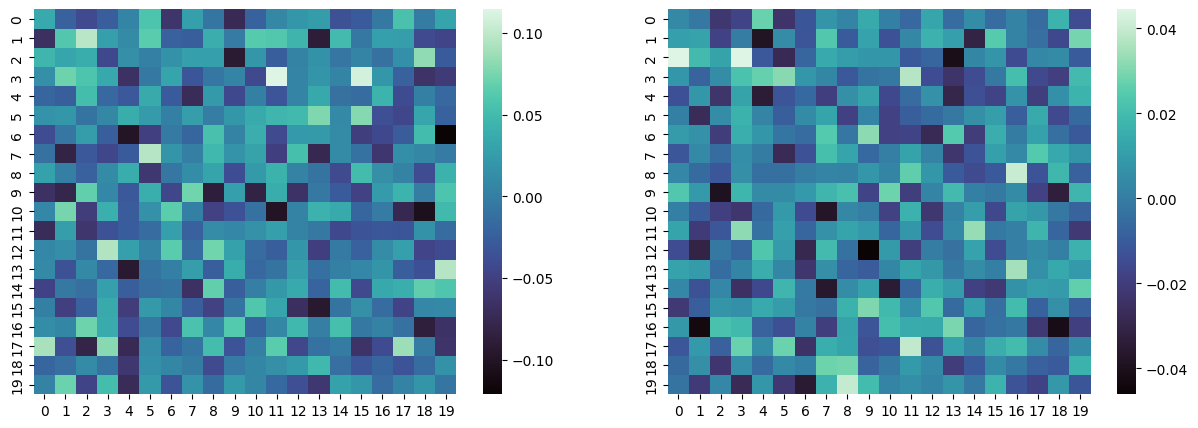

<Figure size 640x480 with 0 Axes>

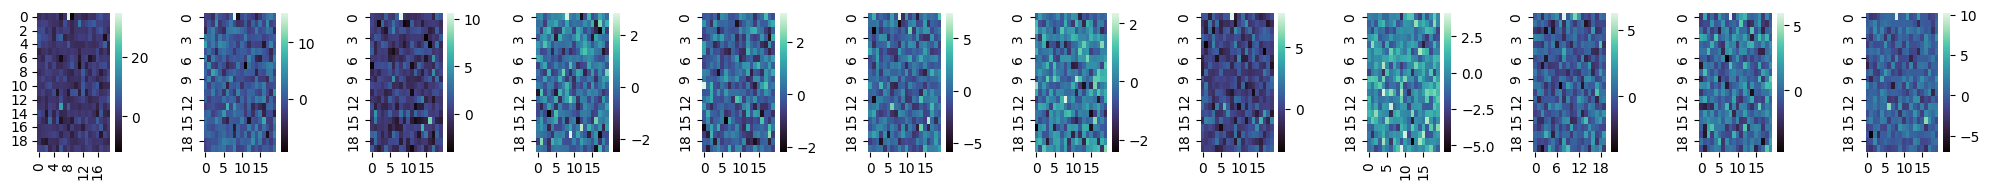

<Figure size 640x480 with 0 Axes>

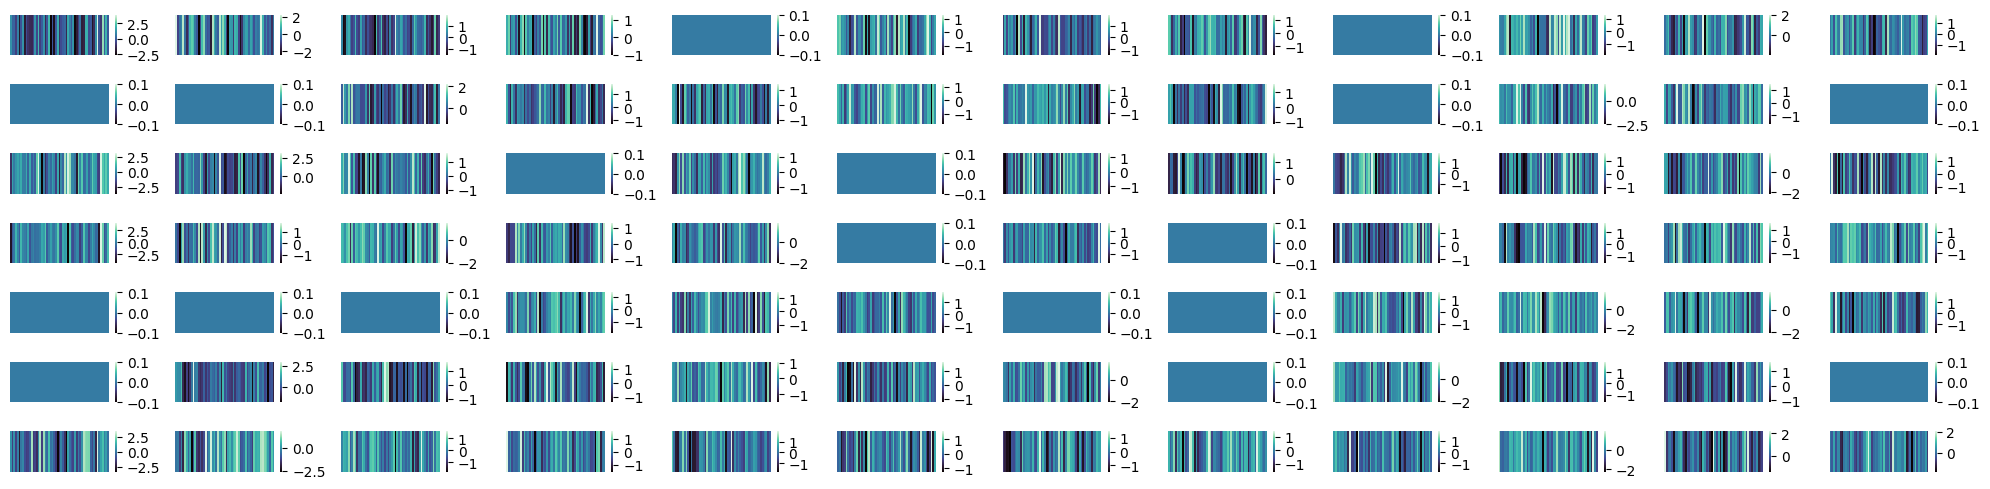

<Figure size 640x480 with 0 Axes>

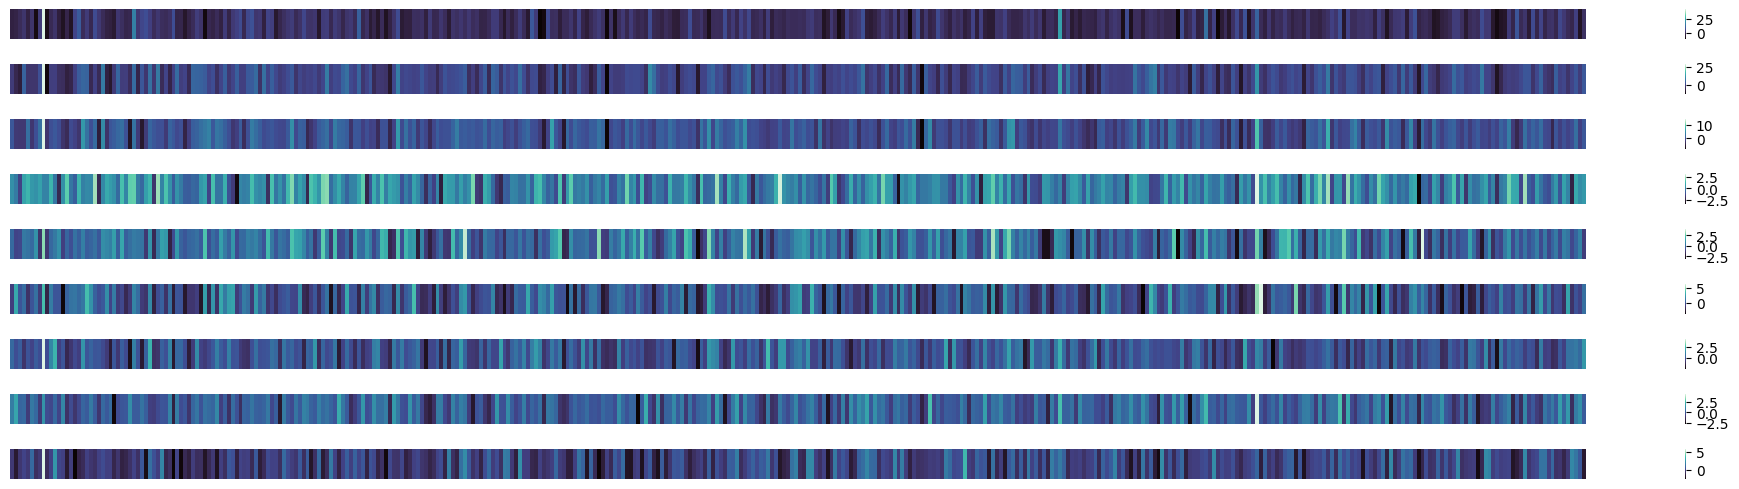

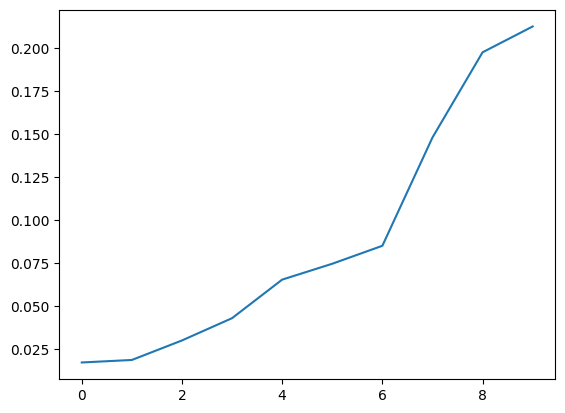

['None', 'Ground', 'Dragon', 'Weakness Policy', 'Focus Sash', 'Safety Goggles', 'Dark', 'Black Sludge', 'Psychic', 'Poison']


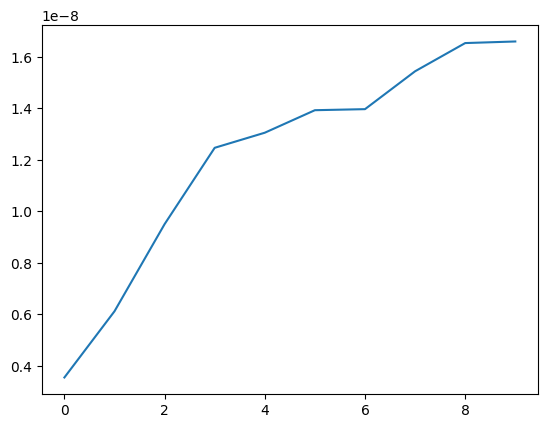

['Soft Boiled', '130', '66', 'Grass Pledge', '50', '86', 'Origin Pulse', 'Minimize', '58', 'Secret Power']
[3.552076854873576e-09, 6.122613527281828e-09, 9.506276654747126e-09, 1.2470002808129266e-08, 1.3055907466252847e-08, 1.3929932762835051e-08, 1.3970590018175244e-08, 1.5441530720750052e-08, 1.653658188160989e-08, 1.6598358243413713e-08]


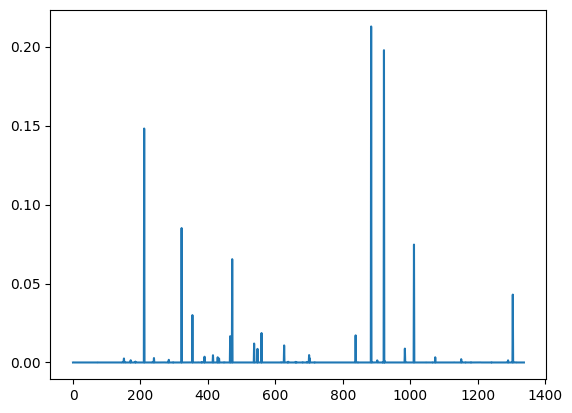

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
InputArray = ["Water","Flying","Occa Berry","Adamant","0","252","0","252","0","4","Levitate","Sacred Fire"]
#for InpIter in range(1,len(InputArray)):
#generates an output given an input
inp = torch.tensor(encode(InputArray[:1]), dtype=torch.long)#
final = model.generateAttentionMap(inp.to(device))
#final output of the transformer
out = final[0][0]
#probabilities of each token being output
probs = final[1]
plot_probs = probs[0].tolist()
#sorting the probabilities to find the most likely and least likely to be chosen as the output and getting their indexes
sortedProbsIndexes = sorted(range(len(plot_probs)), key=lambda k: plot_probs[k])[-10:]
worstSortedProbsIndexes = sorted(range(len(plot_probs)), key=lambda k: plot_probs[k])[:10]
plot_probs.sort()
xAxis = []
worstXAxis = []
#getting the token and positional embeddings
TokenEmbeddings = final[3].detach().cpu().numpy()[0][0].reshape(20,20)
PositionalEmbeddings = final[4].detach().cpu().numpy()[0].reshape(20,20)

#Plotting a heatmap of the token and positional embeddings
plt.figure()
Embeddings, axar = plt.subplots(1,2,figsize=(15,5)) 
sns.heatmap(TokenEmbeddings,ax=axar[0],cmap="mako")
sns.heatmap(PositionalEmbeddings,ax=axar[1],cmap="mako")

#decoding the tokens to see what are the most and least probable outputs
for x in sortedProbsIndexes:
    xAxis.append(decode([x]))
for x in worstSortedProbsIndexes:
    worstXAxis.append(decode([x]))


#plotting the attention maps and creating arrays to sort through the maps and find what output the attention nodes impact
plt.figure()
f, axarr = plt.subplots(1,len(final[2]),figsize=(20,2),layout="tight") 
BestAttentionsArray = []
WorstAttentionsArray = []

for map in range(len(final[2])):
    attentionMap1 = final[2][map][0].detach().cpu().numpy()
    #print(attentionMap1.shape)
    sns.heatmap(attentionMap1.reshape(20,20),ax=axarr[map],cmap="mako")
    sortedAttentionIndexes = sorted(range(len(attentionMap1[0])), key=lambda k: attentionMap1[0][k])[-10:]
    smallestSortedAttentionIndexes = sorted(range(len(attentionMap1[0])), key=lambda k: attentionMap1[0][k])[:10]
    attentionMap1[0].sort()
    #print(attentionMap1[0][-10:])
    bestAttention = []
    for i in range(0,10):
        bestAttention.append(sortedAttentionIndexes[i])
    #print(bestAttention)
    BestAttentionsArray.append(bestAttention)
    worstAttention = []
    for i in range(0,10):
        worstAttention.append(smallestSortedAttentionIndexes[i])
    #print(bestAttention)
    WorstAttentionsArray.append(worstAttention)
plt.savefig("AttentionOutputsRetrainedBit0.jpg")
    

ReshapedBAA = np.array(BestAttentionsArray).reshape(np.array(BestAttentionsArray).size).tolist()
AttentionArrayDict = {e:ReshapedBAA.count(e) for e in set(ReshapedBAA)}
print({k: v for k, v in sorted(AttentionArrayDict.items(), key=lambda item: item[1])})

ReshapedWAA = np.array(WorstAttentionsArray).reshape(np.array(BestAttentionsArray).size).tolist()
WorstAttentionArrayDict = {e:ReshapedWAA.count(e) for e in set(ReshapedWAA)}
print({k: v for k, v in sorted(WorstAttentionArrayDict.items(), key=lambda item: item[1])})

try:
    if len(final[5]) > 1:
        plt.figure()
        f, axarr = plt.subplots(1,len(final[5]),figsize=(5,2)) 
        BestAttentionsArray = []
        WorstAttentionsArray = []
        #sns.heatmap(final[-1].reshape(20,20).detach().cpu().numpy(),ax=axa,cmap="PiYG")
        
        for map in range(len(final[5])):
            attentionMap1 = final[5][map][0].detach().cpu().numpy()

            
            sns.heatmap(attentionMap1.reshape(20,20),ax=axarr[map],cmap="mako")
        
        
    #except:
    else:
        plt.figure()
        f, axarr = plt.subplots(1,len(final[5]),figsize=(5,5)) 
        BestAttentionsArray = []
        WorstAttentionsArray = []
        #sns.heatmap(final[-1].reshape(20,20).detach().cpu().numpy(),ax=axa,cmap="PiYG")
        #for map in range(len(final[5])):
        attentionMap1 = final[5][0].detach().cpu().numpy()
        #print(attentionMap1.shape)
        sns.heatmap(attentionMap1.reshape(20,20),ax=axarr,cmap="mako")
except:
    pass
plt.figure()
f, axarr = plt.subplots(Number_Heads,Layers_amount,figsize=(20,5),layout="tight") 
f.tight_layout()

print(np.array(final[6]).shape)
for block in range(np.array(final[6]).shape[0]):
    for head in range(np.array(final[6]).shape[1]):
        attentionMap1 = final[6][block][head][0][0]
        
        #print(attentionMap1)
        #print(attentionMap1.shape)
        axarr[head,block].axis("off")
        sns.heatmap(attentionMap1.reshape(1,Embedding_neurons // Number_Heads),ax=axarr[head,block],cmap="mako")
plt.savefig("AttentionMapsRetrainedBit0.jpg")
try:
    final[7][4][0][0]
    plt.figure()
    f, axarr = plt.subplots(9,1,figsize=(20,5),layout="tight") 
    f.tight_layout()
    print(np.array(final[7]).shape)
    for block in range(9):
        #for head in range(np.array(final[7]).shape[1]):
        attentionMap1 = final[7][block][0][0]
        #print(attentionMap1)
        #print(attentionMap1)
        #print(attentionMap1.shape)
        axarr[block].axis("off")
        sns.heatmap(attentionMap1.reshape(1,400),ax=axarr[block],cmap="mako")
    plt.savefig("PrunedLayerOutput.jpg")
except:
    pass
#plotting the outputs
plt.figure
plot, axa = plt.subplots(1,1) 
plt.plot(plot_probs[-10:])
plt.show()
print(xAxis)
plt.figure
plot, axa = plt.subplots(1,1) 
plt.plot(plot_probs[:10])
plt.show()
print(worstXAxis)
print(plot_probs[:10])
plt.figure
plot, axa = plt.subplots(1,1) 
plt.plot(probs[0].tolist())
plt.show()

#print()

#Findings:
#The index of an attention node directly corresponds to the output probability of a transformer
#you can actually tell what the transformer focused on and link it back to the attention matrices
#temperature can offset this and make the transformer less explainable since there is a degree of randomness to it
#to prevent temperature negatively effecting the explainability, i turn temperature down and create a more deterministic model
#for models that need to be explainable like for medicine it is advised to use more deterministic models since you dont want randomness in a diagnosis



In [ ]:

for iter in range(401):
   
    # every once in a while evaluate the loss on train and val sets
    if iter % Evaluation_Intervals == 0 or iter == Max_iterations - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        save(model)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.4545, val loss 1.3491


In [273]:
def GenerateRandomPokemon():
    Types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 
            'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

    Items = ['Protective Pads', 'Bright Powder', 'Lansat Berry', 'Absorb Bulb', 'Iron Ball', 'Occa Berry', 
    'Scope Lens', 'Flame Orb', 'Weakness Policy', 'Quick Claw', 'Spell Tag', 'Sharp Beak', 'Grassy Seed', 
    'Griseous Orb', 'Rocky Helmet', 'Muscle Band', 'White Herb', 'Metal Coat', 'Rawst Berry', 'Dragon Fang', 
    'Colbur Berry', 'Choice Specs', 'Liechi Berry', 'Light Clay', 'Toxic Orb', 'Adrenaline Orb', 'Red Card', 
    'Pixie Plate', 'Power Anklet', 'Wiki Berry', 'Kee Berry', 'Rindo Berry', 'Power Herb', 'Zoom Lens', 
    'Blunder Policy', 'Figy Berry', 'Room Service', 'Charcoal', 'Coba Berry', 'Eject Pack', 'Poison Barb', 
    'Rusted Shield', 'Chesto Berry', 'Heavy-Duty Boots', 'Eviolite', 'Lagging Tail', 'Payapa Berry', 'Sea Incense', 
    'Sitrus Berry', 'Black Belt', 'Full Incense', 'Silk Scarf', 'Adamant Orb', 'Heat Rock', 'Leek', 'Normal Gem', 
    'Binding Band', 'Mystic Water', 'Wacan Berry', 'Psychic Seed', 'Rusted Sword', 'Black Sludge', 'Lum Berry', 
    'Iapapa Berry', 'Metronome', 'Chople Berry', 'Custap Berry', 'Never-Melt Ice', 'Focus Sash', 'Thick Club', 
    'Shuca Berry', 'Razor Claw', 'Charti Berry', 'Utility Umbrella', 'Assault Vest', 'Damp Rock', 'Life Orb', 
    'Haban Berry', 'Light Ball', 'Misty Seed', 'Babiri Berry', 'Starf Berry', 'Magnet', 'Power Lens', 'Expert Belt', 
    'Mental Herb', 'Miracle Seed', 'Twisted Spoon', 'Safety Goggles', 'Throat Spray', 'Smooth Rock', 'Leftovers', 
    'Eject Button', 'Kasib Berry', 'Cell Battery', 'Rose Incense', 'Wise Glasses', 'Wave Incense', 'Passho Berry', 
    'Choice Scarf', 'Electric Seed', 'Choice Band', 'Roseli Berry', 'Snowball', 'Wide Lens', 'Mago Berry', 'Focus Band', 
    'Lustrous Orb', 'Black Glasses', 'Aguav Berry', 'Air Balloon', 'Salac Berry', 'Yache Berry']
    
    Moves = ["Absorb","Accelerock","Acid","Acid Armor","Acid Spray","Acrobatics","Acupressure","Aerial Ace","Aeroblast","After You","Agility","Air Cutter","Air Slash","Ally Switch","Amnesia","Anchor Shot","Ancient Power","Apple Acid","Aqua Jet","Aqua Ring","Aqua Tail","Arm Thrust","Aromatherapy","Aromatic Mist","Assist","Assurance","Astonish","Astral Barrage","Attack Order","Attract","Aura Sphere","Aura Wheel","Aurora Beam","Aurora Veil","Autotomize","Avalanche","Baby Doll Eyes","Baddy Bad","Baneful Bunker","Barrage","Barrier","Baton Pass","Beak Blast","Beat Up","Behemoth Bash","Behemoth Blade","Belch","Belly Drum","Bestow","Bide","Bind","Bite","Blast Burn","Blaze Kick","Blizzard","Block","Blue Flare","Body Press","Body Slam","Bolt Beak","Bolt Strike","Bone Club","Bone Rush","Bonemerang","Boomburst","Bounce","Bouncy Bubble","Branch Poke","Brave Bird","Breaking Swipe","Brick Break","Brine","Brutal Swing","Bubble","Bubble Beam","Bug Bite","Bug Buzz","Bulk Up","Bulldoze","Bullet Punch","Bullet Seed","Burn Up","Burning Jealousy","Buzzy Buzz","Calm Mind","Camouflage","Captivate","Catastropika","Celebrate","Charge","Charge Beam","Charm","Chatter","Chip Away","Circle Throw","Clamp","Clanging Scales","Clangorous Soul","Clangorous Soulblaze","Clear Smog","Close Combat","Coaching","Coil","Comet Punch","Confide","Confuse Ray","Confusion","Constrict","Conversion","Conversion 2","Copycat","Core Enforcer","Corrosive Gas","Cosmic Power","Cotton Guard","Cotton Spore","Counter","Court Change","Covet","Crabhammer","Crafty Shield","Cross Chop","Cross Poison","Crunch","Crush Claw","Crush Grip","Curse","Cut","Dark Pulse","Dark Void","Darkest Lariat","Dazzling Gleam","Decorate","Defend Order","Defense Curl","Defog","Destiny Bond","Detect","Diamond Storm","Dig","Disable","Disarming Voice","Discharge","Dive","Dizzy Punch","Doom Desire","Double Edge","Double Hit","Double Iron Bash","Double Kick","Double Slap","Double Team","Draco Meteor","Dragon Ascent","Dragon Breath","Dragon Claw","Dragon Dance","Dragon Darts","Dragon Energy","Dragon Hammer","Dragon Pulse","Dragon Rage","Dragon Rush","Dragon Tail","Drain Punch","Draining Kiss","Dream Eater","Drill Peck","Drill Run","Drum Beating","Dual Chop","Dual Wingbeat","Dynamax Cannon","Dynamic Punch","Earth Power","Earthquake","Echoed Voice","Eerie Impulse","Eerie Spell","Egg Bomb","Electric Terrain","Electrify","Electro Ball","Electroweb","Embargo","Ember","Encore","Endeavor","Endure","Energy Ball","Entrainment","Eruption","Eternabeam","Expanding Force","Explosion","Extrasensory","Extreme Evoboost","Extreme Speed","Facade","Fairy Lock","Fairy Wind","Fake Out","Fake Tears","False Surrender","False Swipe","Feather Dance","Feint","Feint Attack","Fell Stinger","Fiery Dance","Fiery Wrath","Final Gambit","Fire Blast","Fire Fang","Fire Lash","Fire Pledge","Fire Punch","Fire Spin","First Impression","Fishious Rend","Fissure","Flail","Flame Burst","Flame Charge","Flame Wheel","Flamethrower","Flare Blitz","Flash","Flash Cannon","Flatter","Fleur Cannon","Fling","Flip Turn","Floaty Fall","Floral Healing","Flower Shield","Fly","Flying Press","Focus Blast","Focus Energy","Focus Punch","Follow Me","Force Palm","Foresight","Forest'S Curse","Foul Play","Freeze Dry","Freeze Shock","Freezing Glare","Freezy Frost","Frenzy Plant","Frost Breath","Frustration","Fury Attack","Fury Cutter","Fury Swipes","Fusion Bolt","Fusion Flare","Future Sight","Gastro Acid","Gear Grind","Gear Up","Genesis Supernova","Geomancy","Giga Drain","Giga Impact","Glacial Lance","Glaciate","Glare","Glitzy Glow","Grass Knot","Grass Pledge","Grass Whistle","Grassy Glide","Grassy Terrain","Grav Apple","Gravity","Growl","Growth","Grudge","Guard Split","Guard Swap","Guardian Of Alola","Guillotine","Gunk Shot","Gust","Gyro Ball","Hail","Hammer Arm","Happy Hour","Harden","Haze","Head Charge","Head Smash","Headbutt","Heal Bell","Heal Block","Heal Order","Heal Pulse","Healing Wish","Heart Stamp","Heart Swap","Heat Crash","Heat Wave","Heavy Slam","Helping Hand","Hex","Hidden Power","High Horsepower","High Jump Kick","Hold Back","Hold Hands","Hone Claws","Horn Attack","Horn Drill","Horn Leech","Howl","Hurricane","Hydro Cannon","Hydro Pump","Hyper Beam","Hyper Fang","Hyper Voice","Hyperspace Fury","Hyperspace Hole","Hypnosis","Ice Ball","Ice Beam","Ice Burn","Ice Fang","Ice Hammer","Ice Punch","Ice Shard","Icicle Crash","Icicle Spear","Icy Wind","Imprison","Incinerate","Inferno","Infestation","Ingrain","Instruct","Ion Deluge","Iron Defense","Iron Head","Iron Tail","Jaw Lock","Judgment","Jump Kick","Jungle Healing","Karate Chop","Kinesis","King'S Shield","Knock Off","Land'S Wrath","Laser Focus","Lash Out","Last Resort","Lava Plume","Leaf Blade","Leaf Storm","Leaf Tornado","Leafage","Leech Life","Leech Seed","Leer","Lick","Life Dew","Light Of Ruin","Light Screen","Light That Burns The Sky","Liquidation","Lock On","Lovely Kiss","Low Kick","Low Sweep","Lucky Chant","Lunar Dance","Lunge","Luster Purge","Mach Punch","Magic Coat","Magic Powder","Magic Room","Magical Leaf","Magma Storm","Magnet Bomb","Magnet Rise","Magnetic Flux","Magnitude","Malicious Moonsault","Mat Block","Max Airstream","Max Darkness","Max Flare","Max Flutterby","Max Geyser","Max Guard","Max Hailstorm","Max Knuckle","Max Lightning","Max Mindstorm","Max Ooze","Max Overgrowth","Max Phantasm","Max Quake","Max Rockfall","Max Starfall","Max Steelspike","Max Strike","Max Wyrmwind","Me First","Mean Look","Meditate","Mega Drain","Mega Kick","Mega Punch","Megahorn","Memento","Menacing Moonraze Maelstrom","Metal Burst","Metal Claw","Metal Sound","Meteor Assault","Meteor Beam","Meteor Mash","Metronome","Milk Drink","Mimic","Mind Blown","Mind Reader","Minimize","Miracle Eye","Mirror Coat","Mirror Move","Mirror Shot","Mist","Mist Ball","Misty Explosion","Misty Terrain","Moonblast","Moongeist Beam","Moonlight","Morning Sun","Mud Bomb","Mud Shot","Mud Slap","Mud Sport","Muddy Water","Multi Attack","Mystical Fire","Nasty Plot","Natural Gift","Nature Power","Nature'S Madness","Needle Arm","Night Daze","Night Shade","Night Slash","Nightmare","No Retreat","Noble Roar","Nuzzle","Oblivion Wing","Obstruct","Oceanic Operetta","Octazooka","Octolock","Odor Sleuth","Ominous Wind","Origin Pulse","Outrage","Overdrive","Overheat","Pain Split","Parabolic Charge","Parting Shot","Pay Day","Payback","Peck","Perish Song","Petal Blizzard","Petal Dance","Phantom Force","Photon Geyser","Pika Papow","Pin Missile","Plasma Fists","Play Nice","Play Rough","Pluck","Poison Fang","Poison Gas","Poison Jab","Poison Powder","Poison Sting","Poison Tail","Pollen Puff","Pound","Powder","Powder Snow","Power Gem","Power Split","Power Swap","Power Trick","Power Trip","Power Up Punch","Power Whip","Precipice Blades","Present","Prismatic Laser","Protect","Psybeam","Psych Up","Psychic","Psychic Fangs","Psychic Terrain","Psycho Boost","Psycho Cut","Psycho Shift","Psyshock","Psystrike","Psywave","Pulverizing Pancake","Punishment","Purify","Pursuit","Pyro Ball","Quash","Quick Attack","Quick Guard","Quiver Dance","Rage","Rage Powder","Rain Dance","Rapid Spin","Razor Leaf","Razor Shell","Razor Wind","Recover","Recycle","Reflect","Reflect Type","Refresh","Relic Song","Rest","Retaliate","Return","Revelation Dance","Revenge","Reversal","Rising Voltage","Roar","Roar Of Time","Rock Blast","Rock Climb","Rock Polish","Rock Slide","Rock Smash","Rock Throw","Rock Tomb","Rock Wrecker","Role Play","Rolling Kick","Rollout","Roost","Rototiller","Round","Sacred Fire","Sacred Sword","Safeguard","Sand Attack","Sand Tomb","Sandstorm","Sappy Seed","Scald","Scale Shot","Scary Face","Scorching Sands","Scratch","Screech","Searing Shot","Searing Sunraze Smash","Secret Power","Secret Sword","Seed Bomb","Seed Flare","Seismic Toss","Self Destruct","Shadow Ball","Shadow Bone","Shadow Claw","Shadow Force","Shadow Punch","Shadow Sneak","Sharpen","Sheer Cold","Shell Side Arm","Shell Smash","Shell Trap","Shift Gear","Shock Wave","Shore Up","Signal Beam","Silver Wind","Simple Beam","Sing","Sinister Arrow Raid","Sizzly Slide","Sketch","Skill Swap","Skitter Smack","Skull Bash","Sky Attack","Sky Drop","Sky Uppercut","Slack Off","Slam","Slash","Sleep Powder","Sleep Talk","Sludge","Sludge Bomb","Sludge Wave","Smack Down","Smart Strike","Smelling Salts","Smog","Smokescreen","Snap Trap","Snarl","Snatch","Snipe Shot","Snore","Soak","Soft Boiled","Solar Beam","Solar Blade","Sonic Boom","Soul Stealing 7 Star Strike","Spacial Rend","Spark","Sparkling Aria","Sparkly Swirl","Spectral Thief","Speed Swap","Spider Web","Spike Cannon","Spikes","Spiky Shield","Spirit Break","Spirit Shackle","Spit Up","Spite","Splash","Splintered Stormshards","Splishy Splash","Spore","Spotlight","Stealth Rock","Steam Eruption","Steamroller","Steel Beam","Steel Roller","Steel Wing","Sticky Web","Stockpile","Stoked Sparksurfer","Stomp","Stomping Tantrum","Stone Edge","Stored Power","Storm Throw","Strange Steam","Strength","Strength Sap","String Shot","Struggle","Struggle Bug","Stuff Cheeks","Stun Spore","Submission","Substitute","Sucker Punch","Sunny Day","Sunsteel Strike","Super Fang","Superpower","Supersonic","Surf","Surging Strikes","Swagger","Swallow","Sweet Kiss","Sweet Scent","Swift","Switcheroo","Swords Dance","Synchronoise","Synthesis","Tackle","Tail Glow","Tail Slap","Tail Whip","Tailwind","Take Down","Tar Shot","Taunt","Tearful Look","Teatime","Techno Blast","Teeter Dance","Telekinesis","Teleport","Terrain Pulse","Thief","Thousand Arrows","Thousand Waves","Thrash","Throat Chop","Thunder","Thunder Cage","Thunder Fang","Thunder Punch","Thunder Shock","Thunder Wave","Thunderbolt","Thunderous Kick","Tickle","Topsy Turvy","Torment","Toxic","Toxic Spikes","Toxic Thread","Transform","Tri Attack","Trick","Trick Or Treat","Trick Room","Triple Axel","Triple Kick","Trop Kick","Trump Card","Twineedle","Twister","U Turn","Uproar","V Create","Vacuum Wave","Veevee Volley","Venom Drench","Venoshock","Vine Whip","Vise Grip","Vital Throw","Volt Switch","Volt Tackle","Wake Up Slap","Water Gun","Water Pledge","Water Pulse","Water Shuriken","Water Sport","Water Spout","Waterfall","Weather Ball","Whirlpool","Whirlwind","Wicked Blow","Wide Guard","Wild Charge","Will O Wisp","Wing Attack","Wish","Withdraw","Wonder Room","Wood Hammer","Work Up","Worry Seed","Wrap","Wring Out","X Scissor","Yawn","Zap Cannon","Zen Headbutt","Zing Zap","Zippy Zap","G-Max Vine Lash","G-Max Wildfire","G-Max Cannonade","G-Max Befuddle","G-Max Volt Crash","G-Max Gold Rush","G-Max Chi Strike","G-Max Terror","G-Max Foam Burst","G-Max Resonance","G-Max Cuddle","G-Max Replenish","G-Max Malodor","G-Max Meltdown","G-Max Drum Solo","G-Max Fireball","G-Max Hydrosnipe","G-Max Wind Rage","G-Max Gravitas","G-Max Stonesurge","G-Max Volcalith","G-Max Tartness","G-Max Sweetness","G-Max Sandblast","G-Max Stun Shock","G-Max Centiferno","G-Max Smite","G-Max Snooze","G-Max Finale","G-Max Steelsurge","G-Max Depletion","G-Max One Blow","G-Max Rapid Flow"]
    
    # read the data from the csv
    device = 'cuda'
    alphabet = Alphabet
    Type1 = Types[random.randint(0,len(Types)-1)]
    
    Type2 = Types[random.randint(0,len(Types)-1)]
    while Type2 == Type1:
        Type2 = Types[random.randint(0,len(Types)-1)]
    Item = Items[random.randint(0,len(Items)-1)]
    inputText = [Type1,Type2]
    #print(inputText)
    
    with open('AlphabetFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().replace("\n","")
    #chars = sorted(list(set(texts.split(","))))#+sorted(list(set(text)))
    
    # here are all the unique characters that occur in this text
    chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))
    vocab_size = len(chars)
    # create a mapping from characters to integers
    stoiT = { ch:i for i,ch in enumerate(chars) }
    itosT = { i:ch for i,ch in enumerate(chars) }
    encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
    decoder = lambda l: ','.join([itosT[i] for i in l])
    outputArr = []
    #for i in range(0,1):

    dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cuda')
    #dataT = dataT.detach().numpy()

    #print(list(dataT))
    temp = []
    for i in range(0,len(list(dataT))):
        temp.append(dataT[i])
    #print(temp)
    dataT = torch.tensor(temp, dtype=torch.long,device='cuda')
    #print(dataT)
    context = dataT.to(device)#torch.tensor(dataInput)


    output = (decoder(model.generate(context.reshape(1,len(context)), max_new_tokens=Block_size-len(inputText))[0].tolist()))
    outputArr.append(output)
    #print(output.split(","))
    return output.split(",")

In [274]:
def AutoCorrect(Pokemon):
    with open('AlphabetFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().replace("\n","")
#chars = sorted(list(set(texts.split(","))))#+sorted(list(set(text)))
    flag = True
    # here are all the unique characters that occur in this text
    chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))
    stoiT = { ch:i for i,ch in enumerate(chars) }
    itosT = { i:ch for i,ch in enumerate(chars) }
    encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
    decoder = lambda l: ','.join([itosT[i] for i in l])
    
    Types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 
            'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

    Items = ['Protective Pads', 'Bright Powder', 'Lansat Berry', 'Absorb Bulb', 'Iron Ball', 'Occa Berry', 
    'Scope Lens', 'Flame Orb', 'Weakness Policy', 'Quick Claw', 'Spell Tag', 'Sharp Beak', 'Grassy Seed', 
    'Griseous Orb', 'Rocky Helmet', 'Muscle Band', 'White Herb', 'Metal Coat', 'Rawst Berry', 'Dragon Fang', 
    'Colbur Berry', 'Choice Specs', 'Liechi Berry', 'Light Clay', 'Toxic Orb', 'Adrenaline Orb', 'Red Card', 
    'Pixie Plate', 'Power Anklet', 'Wiki Berry', 'Kee Berry', 'Rindo Berry', 'Power Herb', 'Zoom Lens', 
    'Blunder Policy', 'Figy Berry', 'Room Service', 'Charcoal', 'Coba Berry', 'Eject Pack', 'Poison Barb', 
    'Rusted Shield', 'Chesto Berry', 'Heavy-Duty Boots', 'Eviolite', 'Lagging Tail', 'Payapa Berry', 'Sea Incense', 
    'Sitrus Berry', 'Black Belt', 'Full Incense', 'Silk Scarf', 'Adamant Orb', 'Heat Rock', 'Leek', 'Normal Gem', 
    'Binding Band', 'Mystic Water', 'Wacan Berry', 'Psychic Seed', 'Rusted Sword', 'Black Sludge', 'Lum Berry', 
    'Iapapa Berry', 'Metronome', 'Chople Berry', 'Custap Berry', 'Never-Melt Ice', 'Focus Sash', 'Thick Club', 
    'Shuca Berry', 'Razor Claw', 'Charti Berry', 'Utility Umbrella', 'Assault Vest', 'Damp Rock', 'Life Orb', 
    'Haban Berry', 'Light Ball', 'Misty Seed', 'Babiri Berry', 'Starf Berry', 'Magnet', 'Power Lens', 'Expert Belt', 
    'Mental Herb', 'Miracle Seed', 'Twisted Spoon', 'Safety Goggles', 'Throat Spray', 'Smooth Rock', 'Leftovers', 
    'Eject Button', 'Kasib Berry', 'Cell Battery', 'Rose Incense', 'Wise Glasses', 'Wave Incense', 'Passho Berry', 
    'Choice Scarf', 'Electric Seed', 'Choice Band', 'Roseli Berry', 'Snowball', 'Wide Lens', 'Mago Berry', 'Focus Band', 
    'Lustrous Orb', 'Black Glasses', 'Aguav Berry', 'Air Balloon', 'Salac Berry', 'Yache Berry']

    Natures = ['Quirky', 'Hasty', 'Impish', 'Mild', 'Brave', 'Bold', 'Jolly', 'Naive', 'Calm', 'Relaxed',
    'Bashful', 'Timid', 'Rash', 'Careful', 'Quiet', 'Gentle', 'Hardy', 'Serious', 'Adamant', 'Docile', 'Modest', 'Lonely', 'Sassy', 'Naughty', 'Lax']

    Abilities = ['Adaptability', 'Aftermath', 'Air Lock', 'Analytic', 'Anger Point', 'Anticipation', 'Arena Trap', 'Aroma Veil', 'Aura Break', 
    'Battery', 'Battle Armor', 'Beast Boost', 'Berserk', 'Big Pecks', 'Blaze', 'Bulletproof', 'Cheek Pouch', 'Chilling Neigh', 'Chlorophyll', 
    'Clear Body', 'Cloud Nine', 'Competitive', 'Compound Eyes', 'Contrary', 'Corrosion', 'Cotton Down', 'Cursed Body', 'Cute Charm', 'Damp', 
    'Dark Aura', 'Dauntless Shield', 'Defiant', 'Disguise', 'Download', 'Drizzle', 'Drought', 'Dry Skin', 'Early Bird', 'Effect Spore', 
    'Electric Surge', 'Emergency Exit', 'Fairy Aura', 'Filter', 'Flame Body', 'Flare Boost', 'Flash Fire', 'Flower Gift', 'Flower Veil', 
    'Fluffy', 'Friend Guard', 'Frisk', 'Full Metal Body', 'Fur Coat', 'Gale Wings', 'Gluttony', 'Gooey', 'Gorilla Tactics', 'Grassy Surge', 
    'Grim Neigh', 'Guts', 'Harvest', 'Healer', 'Heatproof', 'Heavy Metal', 'Honey Gather', 'Huge Power', 'Hunger Switch', 'Hustle', 'Hydration', 
    'Hyper Cutter', 'Ice Body', 'Ice Face', 'Illuminate', 'Illusion', 'Immunity', 'Imposter', 'Infiltrator', 'Inner Focus', 'Insomnia', 'Intimidate', 
    'Intrepid Sword', 'Iron Barbs', 'Iron Fist', 'Justified', 'Keen Eye', 'Klutz', 'Leaf Guard', 'Levitate', 'Libero', 'Light Metal', 'Lightning Rod', 
    'Limber', 'Liquid Ooze', 'Liquid Voice', 'Long Reach', 'Magic Bounce', 'Magic Guard', 'Magician', 'Magnet Pull', 'Marvel Scale', 'Mega Launcher', 
    'Merciless', 'Minus', 'Mirror Armor', 'Misty Surge', 'Mold Breaker', 'Motor Drive', 'Moxie', 'Multiscale', 'Mummy', 'Natural Cure', 'Neutralizing Gas', 
    'No Guard', 'Oblivious', 'Overcoat', 'Overgrow', 'Own Tempo', 'Perish Body', 'Pickpocket', 'Pickup', 'Pixilate', 'Plus', 'Poison Point', 'Poison Touch', 
    'Power Construct', 'Power Spot', 'Prankster', 'Pressure', 'Prism Armor', 'Propeller Tail', 'Psychic Surge', 'Punk Rock', 'Queenly Majesty', 'Quick Draw', 
    'Quick Feet', 'Rain Dish', 'Rattled', 'Receiver', 'Reckless', 'Regenerator', 'Ripen', 'Rivalry', 'Rock Head', 'Rough Skin', 'Run Away', 'Sand Force', 
    'Sand Rush', 'Sand Spit', 'Sand Stream', 'Sand Veil', 'Sap Sipper', 'Schooling', 'Scrappy', 'Screen Cleaner', 'Serene Grace', 'Shadow Shield', 'Shadow Tag',
    'Shed Skin', 'Sheer Force', 'Shell Armor', 'Shield Dust', 'Simple', 'Skill Link', 'Slow Start', 'Slush Rush', 'Sniper', 'Snow Cloak', 'Snow Warning', 
    'Solar Power', 'Solid Rock', 'Soundproof', 'Speed Boost', 'Stakeout', 'Stall', 'Stalwart', 'Stamina', 'Stance Change', 'Static', 'Steadfast', 'Steam Engine',
    'Steelworker', 'Steely Spirit', 'Stench', 'Sticky Hold', 'Storm Drain', 'Strong Jaw', 'Sturdy', 'Suction Cups', 'Super Luck', 'Surge Surfer', 'Swarm', 
    'Sweet Veil', 'Swift Swim', 'Symbiosis', 'Synchronize', 'Tangled Feet', 'Technician', 'Telepathy', 'Teravolt', 'Thick Fat', 'Tinted Lens', 'Torrent', 
    'Tough Claws', 'Trace', 'Transistor', 'Triage', 'Truant', 'Turboblaze', 'Unaware', 'Unburden', 'Unnerve', 'Unseen Fist', 'Vital Spirit', 'Volt Absorb', 
    'Wandering Spirit', 'Water Absorb', 'Water Bubble', 'Water Compaction', 'Water Veil', 'Weak Armor', 'White Smoke', 'Wonder Guard', 'Wonder Skin', 'Zen Mode']

    Moves = ["Absorb","Accelerock","Acid","Acid Armor","Acid Spray","Acrobatics","Acupressure","Aerial Ace","Aeroblast","After You","Agility","Air Cutter","Air Slash","Ally Switch","Amnesia","Anchor Shot","Ancient Power","Apple Acid","Aqua Jet","Aqua Ring","Aqua Tail","Arm Thrust","Aromatherapy","Aromatic Mist","Assist","Assurance","Astonish","Astral Barrage","Attack Order","Attract","Aura Sphere","Aura Wheel","Aurora Beam","Aurora Veil","Autotomize","Avalanche","Baby Doll Eyes","Baddy Bad","Baneful Bunker","Barrage","Barrier","Baton Pass","Beak Blast","Beat Up","Behemoth Bash","Behemoth Blade","Belch","Belly Drum","Bestow","Bide","Bind","Bite","Blast Burn","Blaze Kick","Blizzard","Block","Blue Flare","Body Press","Body Slam","Bolt Beak","Bolt Strike","Bone Club","Bone Rush","Bonemerang","Boomburst","Bounce","Bouncy Bubble","Branch Poke","Brave Bird","Breaking Swipe","Brick Break","Brine","Brutal Swing","Bubble","Bubble Beam","Bug Bite","Bug Buzz","Bulk Up","Bulldoze","Bullet Punch","Bullet Seed","Burn Up","Burning Jealousy","Buzzy Buzz","Calm Mind","Camouflage","Captivate","Catastropika","Celebrate","Charge","Charge Beam","Charm","Chatter","Chip Away","Circle Throw","Clamp","Clanging Scales","Clangorous Soul","Clangorous Soulblaze","Clear Smog","Close Combat","Coaching","Coil","Comet Punch","Confide","Confuse Ray","Confusion","Constrict","Conversion","Conversion 2","Copycat","Core Enforcer","Corrosive Gas","Cosmic Power","Cotton Guard","Cotton Spore","Counter","Court Change","Covet","Crabhammer","Crafty Shield","Cross Chop","Cross Poison","Crunch","Crush Claw","Crush Grip","Curse","Cut","Dark Pulse","Dark Void","Darkest Lariat","Dazzling Gleam","Decorate","Defend Order","Defense Curl","Defog","Destiny Bond","Detect","Diamond Storm","Dig","Disable","Disarming Voice","Discharge","Dive","Dizzy Punch","Doom Desire","Double Edge","Double Hit","Double Iron Bash","Double Kick","Double Slap","Double Team","Draco Meteor","Dragon Ascent","Dragon Breath","Dragon Claw","Dragon Dance","Dragon Darts","Dragon Energy","Dragon Hammer","Dragon Pulse","Dragon Rage","Dragon Rush","Dragon Tail","Drain Punch","Draining Kiss","Dream Eater","Drill Peck","Drill Run","Drum Beating","Dual Chop","Dual Wingbeat","Dynamax Cannon","Dynamic Punch","Earth Power","Earthquake","Echoed Voice","Eerie Impulse","Eerie Spell","Egg Bomb","Electric Terrain","Electrify","Electro Ball","Electroweb","Embargo","Ember","Encore","Endeavor","Endure","Energy Ball","Entrainment","Eruption","Eternabeam","Expanding Force","Explosion","Extrasensory","Extreme Evoboost","Extreme Speed","Facade","Fairy Lock","Fairy Wind","Fake Out","Fake Tears","False Surrender","False Swipe","Feather Dance","Feint","Feint Attack","Fell Stinger","Fiery Dance","Fiery Wrath","Final Gambit","Fire Blast","Fire Fang","Fire Lash","Fire Pledge","Fire Punch","Fire Spin","First Impression","Fishious Rend","Fissure","Flail","Flame Burst","Flame Charge","Flame Wheel","Flamethrower","Flare Blitz","Flash","Flash Cannon","Flatter","Fleur Cannon","Fling","Flip Turn","Floaty Fall","Floral Healing","Flower Shield","Fly","Flying Press","Focus Blast","Focus Energy","Focus Punch","Follow Me","Force Palm","Foresight","Forest'S Curse","Foul Play","Freeze Dry","Freeze Shock","Freezing Glare","Freezy Frost","Frenzy Plant","Frost Breath","Frustration","Fury Attack","Fury Cutter","Fury Swipes","Fusion Bolt","Fusion Flare","Future Sight","Gastro Acid","Gear Grind","Gear Up","Genesis Supernova","Geomancy","Giga Drain","Giga Impact","Glacial Lance","Glaciate","Glare","Glitzy Glow","Grass Knot","Grass Pledge","Grass Whistle","Grassy Glide","Grassy Terrain","Grav Apple","Gravity","Growl","Growth","Grudge","Guard Split","Guard Swap","Guardian Of Alola","Guillotine","Gunk Shot","Gust","Gyro Ball","Hail","Hammer Arm","Happy Hour","Harden","Haze","Head Charge","Head Smash","Headbutt","Heal Bell","Heal Block","Heal Order","Heal Pulse","Healing Wish","Heart Stamp","Heart Swap","Heat Crash","Heat Wave","Heavy Slam","Helping Hand","Hex","Hidden Power","High Horsepower","High Jump Kick","Hold Back","Hold Hands","Hone Claws","Horn Attack","Horn Drill","Horn Leech","Howl","Hurricane","Hydro Cannon","Hydro Pump","Hyper Beam","Hyper Fang","Hyper Voice","Hyperspace Fury","Hyperspace Hole","Hypnosis","Ice Ball","Ice Beam","Ice Burn","Ice Fang","Ice Hammer","Ice Punch","Ice Shard","Icicle Crash","Icicle Spear","Icy Wind","Imprison","Incinerate","Inferno","Infestation","Ingrain","Instruct","Ion Deluge","Iron Defense","Iron Head","Iron Tail","Jaw Lock","Judgment","Jump Kick","Jungle Healing","Karate Chop","Kinesis","King'S Shield","Knock Off","Land'S Wrath","Laser Focus","Lash Out","Last Resort","Lava Plume","Leaf Blade","Leaf Storm","Leaf Tornado","Leafage","Leech Life","Leech Seed","Leer","Lick","Life Dew","Light Of Ruin","Light Screen","Light That Burns The Sky","Liquidation","Lock On","Lovely Kiss","Low Kick","Low Sweep","Lucky Chant","Lunar Dance","Lunge","Luster Purge","Mach Punch","Magic Coat","Magic Powder","Magic Room","Magical Leaf","Magma Storm","Magnet Bomb","Magnet Rise","Magnetic Flux","Magnitude","Malicious Moonsault","Mat Block","Max Airstream","Max Darkness","Max Flare","Max Flutterby","Max Geyser","Max Guard","Max Hailstorm","Max Knuckle","Max Lightning","Max Mindstorm","Max Ooze","Max Overgrowth","Max Phantasm","Max Quake","Max Rockfall","Max Starfall","Max Steelspike","Max Strike","Max Wyrmwind","Me First","Mean Look","Meditate","Mega Drain","Mega Kick","Mega Punch","Megahorn","Memento","Menacing Moonraze Maelstrom","Metal Burst","Metal Claw","Metal Sound","Meteor Assault","Meteor Beam","Meteor Mash","Metronome","Milk Drink","Mimic","Mind Blown","Mind Reader","Minimize","Miracle Eye","Mirror Coat","Mirror Move","Mirror Shot","Mist","Mist Ball","Misty Explosion","Misty Terrain","Moonblast","Moongeist Beam","Moonlight","Morning Sun","Mud Bomb","Mud Shot","Mud Slap","Mud Sport","Muddy Water","Multi Attack","Mystical Fire","Nasty Plot","Natural Gift","Nature Power","Nature'S Madness","Needle Arm","Night Daze","Night Shade","Night Slash","Nightmare","No Retreat","Noble Roar","Nuzzle","Oblivion Wing","Obstruct","Oceanic Operetta","Octazooka","Octolock","Odor Sleuth","Ominous Wind","Origin Pulse","Outrage","Overdrive","Overheat","Pain Split","Parabolic Charge","Parting Shot","Pay Day","Payback","Peck","Perish Song","Petal Blizzard","Petal Dance","Phantom Force","Photon Geyser","Pika Papow","Pin Missile","Plasma Fists","Play Nice","Play Rough","Pluck","Poison Fang","Poison Gas","Poison Jab","Poison Powder","Poison Sting","Poison Tail","Pollen Puff","Pound","Powder","Powder Snow","Power Gem","Power Split","Power Swap","Power Trick","Power Trip","Power Up Punch","Power Whip","Precipice Blades","Present","Prismatic Laser","Protect","Psybeam","Psych Up","Psychic","Psychic Fangs","Psychic Terrain","Psycho Boost","Psycho Cut","Psycho Shift","Psyshock","Psystrike","Psywave","Pulverizing Pancake","Punishment","Purify","Pursuit","Pyro Ball","Quash","Quick Attack","Quick Guard","Quiver Dance","Rage","Rage Powder","Rain Dance","Rapid Spin","Razor Leaf","Razor Shell","Razor Wind","Recover","Recycle","Reflect","Reflect Type","Refresh","Relic Song","Rest","Retaliate","Return","Revelation Dance","Revenge","Reversal","Rising Voltage","Roar","Roar Of Time","Rock Blast","Rock Climb","Rock Polish","Rock Slide","Rock Smash","Rock Throw","Rock Tomb","Rock Wrecker","Role Play","Rolling Kick","Rollout","Roost","Rototiller","Round","Sacred Fire","Sacred Sword","Safeguard","Sand Attack","Sand Tomb","Sandstorm","Sappy Seed","Scald","Scale Shot","Scary Face","Scorching Sands","Scratch","Screech","Searing Shot","Searing Sunraze Smash","Secret Power","Secret Sword","Seed Bomb","Seed Flare","Seismic Toss","Self Destruct","Shadow Ball","Shadow Bone","Shadow Claw","Shadow Force","Shadow Punch","Shadow Sneak","Sharpen","Sheer Cold","Shell Side Arm","Shell Smash","Shell Trap","Shift Gear","Shock Wave","Shore Up","Signal Beam","Silver Wind","Simple Beam","Sing","Sinister Arrow Raid","Sizzly Slide","Sketch","Skill Swap","Skitter Smack","Skull Bash","Sky Attack","Sky Drop","Sky Uppercut","Slack Off","Slam","Slash","Sleep Powder","Sleep Talk","Sludge","Sludge Bomb","Sludge Wave","Smack Down","Smart Strike","Smelling Salts","Smog","Smokescreen","Snap Trap","Snarl","Snatch","Snipe Shot","Snore","Soak","Soft Boiled","Solar Beam","Solar Blade","Sonic Boom","Soul Stealing 7 Star Strike","Spacial Rend","Spark","Sparkling Aria","Sparkly Swirl","Spectral Thief","Speed Swap","Spider Web","Spike Cannon","Spikes","Spiky Shield","Spirit Break","Spirit Shackle","Spit Up","Spite","Splash","Splintered Stormshards","Splishy Splash","Spore","Spotlight","Stealth Rock","Steam Eruption","Steamroller","Steel Beam","Steel Roller","Steel Wing","Sticky Web","Stockpile","Stoked Sparksurfer","Stomp","Stomping Tantrum","Stone Edge","Stored Power","Storm Throw","Strange Steam","Strength","Strength Sap","String Shot","Struggle","Struggle Bug","Stuff Cheeks","Stun Spore","Submission","Substitute","Sucker Punch","Sunny Day","Sunsteel Strike","Super Fang","Superpower","Supersonic","Surf","Surging Strikes","Swagger","Swallow","Sweet Kiss","Sweet Scent","Swift","Switcheroo","Swords Dance","Synchronoise","Synthesis","Tackle","Tail Glow","Tail Slap","Tail Whip","Tailwind","Take Down","Tar Shot","Taunt","Tearful Look","Teatime","Techno Blast","Teeter Dance","Telekinesis","Teleport","Terrain Pulse","Thief","Thousand Arrows","Thousand Waves","Thrash","Throat Chop","Thunder","Thunder Cage","Thunder Fang","Thunder Punch","Thunder Shock","Thunder Wave","Thunderbolt","Thunderous Kick","Tickle","Topsy Turvy","Torment","Toxic","Toxic Spikes","Toxic Thread","Transform","Tri Attack","Trick","Trick Or Treat","Trick Room","Triple Axel","Triple Kick","Trop Kick","Trump Card","Twineedle","Twister","U Turn","Uproar","V Create","Vacuum Wave","Veevee Volley","Venom Drench","Venoshock","Vine Whip","Vise Grip","Vital Throw","Volt Switch","Volt Tackle","Wake Up Slap","Water Gun","Water Pledge","Water Pulse","Water Shuriken","Water Sport","Water Spout","Waterfall","Weather Ball","Whirlpool","Whirlwind","Wicked Blow","Wide Guard","Wild Charge","Will O Wisp","Wing Attack","Wish","Withdraw","Wonder Room","Wood Hammer","Work Up","Worry Seed","Wrap","Wring Out","X Scissor","Yawn","Zap Cannon","Zen Headbutt","Zing Zap","Zippy Zap","G-Max Vine Lash","G-Max Wildfire","G-Max Cannonade","G-Max Befuddle","G-Max Volt Crash","G-Max Gold Rush","G-Max Chi Strike","G-Max Terror","G-Max Foam Burst","G-Max Resonance","G-Max Cuddle","G-Max Replenish","G-Max Malodor","G-Max Meltdown","G-Max Drum Solo","G-Max Fireball","G-Max Hydrosnipe","G-Max Wind Rage","G-Max Gravitas","G-Max Stonesurge","G-Max Volcalith","G-Max Tartness","G-Max Sweetness","G-Max Sandblast","G-Max Stun Shock","G-Max Centiferno","G-Max Smite","G-Max Snooze","G-Max Finale","G-Max Steelsurge","G-Max Depletion","G-Max One Blow","G-Max Rapid Flow"]

    EVs = []
    for i in range(4,10):
        #print(Pokemon[i])
        #print(EVs)
        try:
            lenEVs = len(EVs)
            if(int(Pokemon[i]) or (output[i]) == '0'):
                EVs.append(int(Pokemon[i]))
            if len(EVs) != lenEVs:
                    EVs.append(0)
        except:
            Pokemon[i] = 0
            EVs.append(0)
    #print(EVs)
    if(Pokemon[0] not in Types or Pokemon[0] == "None"):
        
        Pokemon[0] = Types[random.randint(0,len(Types)-1)]
    if(Pokemon[1] not in Types or Pokemon[1] == Pokemon[0]):
        Pokemon[1] = Types[random.randint(0,len(Types)-1)]
    if(Pokemon[2] not in Items):
        #Pokemon[2] = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(2)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(2)])), max_new_tokens=2)[0].tolist())).split(",")[-1]
        flag = False
    if(Pokemon[3] not in Natures):
        #Pokemon[3] = Natures[random.randint(0,len(Natures)-1)]
        flag = False
    if(sum(EVs) >= 510):
        
        flag = False
    #print(EVs)
    for i in range(0,6):
        Pokemon[i+4] = str(EVs[i])
                    
    if(Pokemon[10] not in Abilities):
        flag = False
        #Pokemon[10] = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(10)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(10)])), max_new_tokens=10)[0].tolist())).split(",")[-1]
    for i in range(11,15):
        if Pokemon[i] not in Moves:
            flag = False
            #output = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(i)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(i)])), max_new_tokens=15-i)[0].tolist()))
            #output = output.split(",")
            #Pokemon = output
    Final = ""
    if flag:
        for i in range(0,len(Pokemon)):
            Final += str(Pokemon[i])+","
        return Final
    else:
        return 0

In [275]:
def FindPokemon(Pokemon):

    Type1 = Pokemon.split(",")[0]
    Type2 = Pokemon.split(",")[1]
    Types = Pokemon.split(",")[0]+","+Pokemon.split(",")[1]
    print(Types)
    f = open("PokemonNamesWithTypes.txt","r",encoding="utf-8")
    lines = f.readlines()
    NamesArr = []
    for i in lines:
        #print(i)
        currType1 = i.split(",")[1]
        currType2 = i.split(",")[2]
        #print(currType1,currType2)
        if(currType1 in Types and currType2 in Types):
            NamesArr.append(i.split(",")[0])

    f.close()
    return NamesArr

In [276]:
try: 
    f = open("TestFineTuning219.txt","r",encoding="utf-8")
    TuningLines = f.readlines()
except:
    TuningLines = []
print(len(TuningLines))
numberInFile = len(TuningLines)
counterCorrect = 0
counterAll = 0
while numberInFile < 500:
    
    f = open("TestFineTuning210.txt","a",encoding="utf-8")
    Pokemon = AutoCorrect(GenerateRandomPokemon())
    if Pokemon != 0:
        counterCorrect+=1
        numberInFile+=1
        f.write(Pokemon+"\n")
    counterAll += 1
    f.close()

0


In [217]:
try: 
    f = open("FineTuningPokemon13.txt","r",encoding="utf-8")
    TuningLines = f.readlines()
except:
    TuningLines = []
print(len(TuningLines))
numberInFile = len(TuningLines)
counterCorrect = 0
counterAll = 0
while numberInFile < 235:
    
    f = open("FineTuningPokemon13.txt","a",encoding="utf-8")
    Pokemon = AutoCorrect(GenerateRandomPokemon())
    if Pokemon != 0:
        counterCorrect+=1
    #print(Pokemon)
    
        PokemonNamesArr = FindPokemon(Pokemon)
        for j in PokemonNamesArr:
            if(len(j.split(" ")) == 1):
                f.write(j+","+Pokemon+"\n")
                numberInFile += 1
    counterAll += 1
    
    f.close()
    


0
Bug,Grass
Fairy,Water
Psychic,Ground
Dark,None
Normal,Poison
Steel,Fighting
Grass,None
Bug,Poison
Normal,Electric
Dark,Normal
Flying,Rock
Dark,Ghost
Steel,Rock
Psychic,Water
Grass,Steel
Normal,Fire
Electric,Psychic
Psychic,Fighting
Ice,Ground
Dark,Ice
Dark,Ground
Ground,Psychic
Steel,Fighting
Bug,Steel
Ice,Fire
Electric,Ice
Dragon,Fighting
Fire,Water
Normal,Ice
Ground,Flying
Grass,Ghost
Fairy,Bug
Bug,Dark
Bug,Rock
Ground,Ghost
Ghost,None
Grass,Normal
Flying,Dark
Grass,Ground
Dragon,None
Grass,Steel
Grass,Fire
Fighting,Grass
Ground,Psychic
Ghost,Dragon
Poison,Fire
Ghost,Psychic
Rock,Water
Ground,Flying
Fighting,Dark
Electric,Bug
Ice,Dark
Normal,Fighting
Ice,Water
Ghost,None
Dragon,Dark
Ground,Water
Rock,Ghost
Rock,Psychic
Ghost,Poison
Dragon,None
Steel,Rock
Fire,Dark
Fighting,Bug
Steel,Ice
Poison,Steel
Dark,Bug
Water,Flying
Psychic,Flying
Ground,Steel
Grass,Steel
Water,Fighting
Ghost,Poison
Psychic,Ghost
Fighting,Normal
Dark,Poison
Rock,Normal
Ghost,Flying
Fairy,Normal
Fighting,Bug
Fi

In [218]:
print(counterCorrect/counterAll*100)
#56,75,85,82,76,77,75,72,
#st,ft,f2,f3,f4,f5,f6,f7,

74.07407407407408


In [219]:

#Dondozo @ Aguav Berry  
#Ability: Unaware  
#Tera Type: Water  
#EVs: 252 HP / 252 Atk / 252 Def / 252 SpA / 252 SpD / 252 Spe  
#Adamant Nature  
#- Aqua Tail  
#- Avalanche  
#- Body Press  
#- Body Slam
f = open("FineTuningPokemon13.txt","r",encoding="utf-8")
lines = f.readlines()
#Genned = AutoCorrect(GenerateRandomPokemon()).split(",")[:-1]

def GennedToString(Genned):
    Genned = Genned.split(",")
    Name = Genned[0]
    PokemonString = Name+" @ "+Genned[3]+"\n"+"Ability: "+Genned[11]+"\n"+"EVs: "+Genned[5]+" HP / "+Genned[6]+" Atk / "+Genned[7]+" Def / "+Genned[8]+" SpA / "+Genned[9]+" SpD / "+Genned[10]+" Spe"+"\n"+Genned[4]+" Nature "+"\n"+"- "+Genned[15]+"\n"+"- "+Genned[12]+"\n"+"- "+Genned[13]+"\n"+"- "+Genned[14]+"\n"
    return PokemonString
PokemonStrings = ""
for i in lines:
    PokemonStrings += GennedToString(i)+"\n"
print(PokemonStrings)
f.close()
f = open("BattlePokemon.txt","w",encoding="utf-8")
f.write(PokemonStrings)
f.close()

Azumarill @ Aguav Berry
Ability: Water Absorb
EVs: 0 HP / 252 Atk / 0 Def / 0 SpA / 0 SpD / 0 Spe
Adamant Nature 
- Crabhammer
- Will O Wisp
- Trick Room
- Shadow Sneak

Primarina @ Aguav Berry
Ability: Water Absorb
EVs: 0 HP / 252 Atk / 0 Def / 0 SpA / 0 SpD / 0 Spe
Adamant Nature 
- Crabhammer
- Will O Wisp
- Trick Room
- Shadow Sneak

Claydol @ Focus Sash
Ability: Prankster
EVs: 252 HP / 0 Atk / 0 Def / 0 SpA / 4 SpD / 0 Spe
Sassy Nature 
- Copycat
- Sunny Day
- Coaching
- Quick Guard

Umbreon @ Focus Sash
Ability: Prankster
EVs: 0 HP / 0 Atk / 0 Def / 252 SpA / 0 SpD / 4 Spe
Timid Nature 
- Copycat
- Thunder Wave
- Foul Play
- Fake Tears

Liepard @ Focus Sash
Ability: Prankster
EVs: 0 HP / 0 Atk / 0 Def / 252 SpA / 0 SpD / 4 Spe
Timid Nature 
- Copycat
- Thunder Wave
- Foul Play
- Fake Tears

Zoroark @ Focus Sash
Ability: Prankster
EVs: 0 HP / 0 Atk / 0 Def / 252 SpA / 0 SpD / 4 Spe
Timid Nature 
- Copycat
- Thunder Wave
- Foul Play
- Fake Tears

Thievul @ Focus Sash
Ability: Prank

In [195]:
import pandas as pd
Types = pd.read_csv('Datasets/Typings.csv',delimiter=',', header=None, skiprows=0,names=['Name','Type'])
Names = pd.read_csv('Datasets/Common_Spreads.csv',delimiter=',', header=None, skiprows=0,names=['Nature','IVs','Use_Percentage','Name'])
Gen = pd.read_csv("Datasets/df_pokemon.csv",delimiter=',', header=None, skiprows=0,names=['ID','Name','Species','Variant','Generation','Rarity','Evolves_from','Has_gender_diff','Type1','Type2','Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','image_url','VGC2022_rules','Monthly Usage (k)','Usage Percent (%)','Monthly Rank'])
NameArr = []
f = open("PokemonNamesWithTypes.txt","w",encoding="utf-8")
for index, NameRow in Names.iterrows():
    currentName = str(NameRow['Name'])
    #print(currentName)
    GenName = "p"
    for index2, GenRow in Gen.iterrows():
        #print(str(GenRow['Name']))
        if(currentName.lower() == ((GenRow['Name']).lower())):
            GenName = currentName
            #print(GenName)
    if(currentName not in NameArr and GenName != "p"):
        #NameArr.append(currentName)
        #currentName = str(NameRow['Name'])
        PokemonString = ""
        
        TypeFlag = 0
        for index, TypeRow in Types.iterrows():
            if(str(TypeRow['Name'])== currentName):
                TypeFlag = 1
                PokemonString+=str(TypeRow['Type'])+","
            if(str(TypeRow['Name']) != currentName and TypeFlag == 1):
                if PokemonString.split(",")[1] == "":
                    PokemonString+=str("None")+","

                break
        NameArr.append(currentName)
        f.write(currentName + ","+PokemonString+"\n")

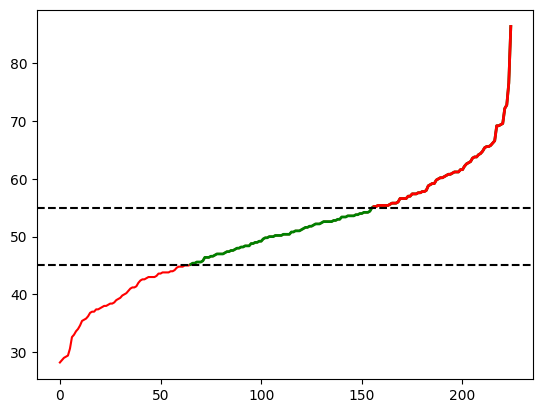

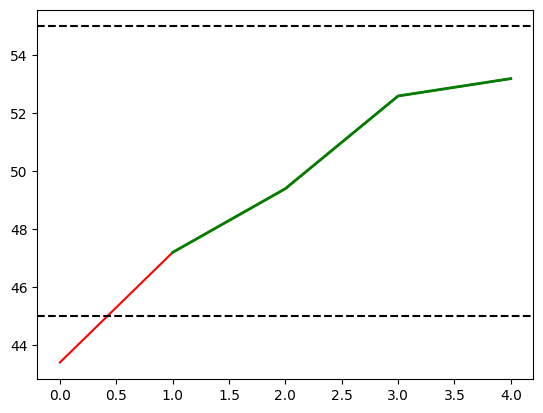

In [241]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
f = open("PokemonWinratesFile2.txt","r")
lines = f.readlines()
arrayOfWinrates = []
for i in lines:
    rates = np.array(i.replace("[","").replace("]","").split(","),dtype=float)
    average = np.average(rates)
    arrayOfWinrates.append(average)

f.close()
#plt.plot(np.sort(arrayOfWinrates))
#plt.show()
a = np.array(np.sort(arrayOfWinrates))

# use a masked array to suppress the values that are too low
a_masked = np.ma.masked_less_equal(a, 55)
b_masked = np.ma.masked_less_equal(a, 45)

# plot the full line
plt.plot(a, 'r')

# plot only the large values
plt.plot(b_masked, 'g', linewidth=2)
plt.plot(a_masked, 'r', linewidth=2)


# add the threshold value (optional)
plt.axhline(55, color='k', linestyle='--')
plt.axhline(45, color='k', linestyle='--')

plt.show()
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
f = open("PokemonWinratesFile13.txt","r")
lines = f.readlines()
arrayOfWinrates2 = []
for i in lines:
    rates = np.array(i.replace("[","").replace("]","").split(","),dtype=float)
    average = np.average(rates)
    arrayOfWinrates2.append(average)

f.close()
#plt.plot(np.sort(arrayOfWinrates))
#plt.show()
a = np.array(np.sort(arrayOfWinrates2))

# use a masked array to suppress the values that are too low
a_masked = np.ma.masked_less_equal(a, 55)
b_masked = np.ma.masked_less_equal(a, 45)

# plot the full line
plt.plot(a, 'r')

# plot only the large values
plt.plot(b_masked, 'g', linewidth=2)
plt.plot(a_masked, 'r', linewidth=2)


# add the threshold value (optional)
plt.axhline(55, color='k', linestyle='--')
plt.axhline(45, color='k', linestyle='--')
plt.savefig("Graphs/Fine-Tuning12")
plt.show()


In [242]:
s = arrayOfWinrates2

sortedList = sorted(range(len(s)), key=lambda k: s[k])
print(arrayOfWinrates2[sortedList[0]],sortedList[-3])
BalancedWinrates = []
for i in range(0,len(arrayOfWinrates2)):
    if arrayOfWinrates2[sortedList[i]] > 45.0 and arrayOfWinrates2[sortedList[i]] < 55.0:
        BalancedWinrates.append(sortedList[i])
print(len(BalancedWinrates))
f = open("FineTuningPokemon12.txt","r",encoding="utf-8")

pokemons = f.read().split("\n")
pokemons = [pokemon.strip(",") for pokemon in sorted(pokemons)][1:]
#print(pokemons[sortedList[70]])
for i in range(len(sortedList)):
    #print(i)
    if(pokemons[sortedList[i]].split(",")[0] == "Exploud"):
        print(arrayOfWinrates2[sortedList[i]])
print(pokemons[sortedList[0]])

43.4 4
4
Aerodactyl,Flying,Rock,Weakness Policy,Relaxed,0,0,0,0,252,0,Punk Rock,Snarl,Volt Switch,Sludge Bomb,Overdrive


83
90
99
103
105
118
90
82
108
103
96
102


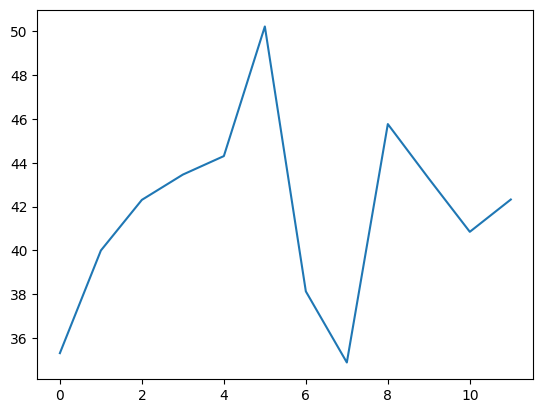

In [222]:
finalWinrates = []
f = open("PokemonWinratesFile.txt","r")
lines = f.readlines()
arrayOfWinrates2 = []
for i in lines:
    rates = np.array(i.replace("[","").replace("]","").split(","),dtype=float)
    average = np.average(rates)
    arrayOfWinrates2.append(average)
s = arrayOfWinrates2
sortedList = sorted(range(len(s)), key=lambda k: s[k])
#print(arrayOfWinrates2[sortedList[0]],sortedList[-3])
BalancedWinrates = []
for i in range(0,len(arrayOfWinrates2)):
    if arrayOfWinrates2[sortedList[i]] > 45.0 and arrayOfWinrates2[sortedList[i]] < 55.0:
        BalancedWinrates.append(sortedList[i])
print(len(BalancedWinrates))
finalWinrates.append(len(BalancedWinrates)/len(lines)*100)
for i in range(2,13):
    f = open(f"PokemonWinratesFile{i}.txt","r")
    lines = f.readlines()
    arrayOfWinrates2 = []
    for i in lines:
        rates = np.array(i.replace("[","").replace("]","").split(","),dtype=float)
        average = np.average(rates)
        arrayOfWinrates2.append(average)
    s = arrayOfWinrates2
    sortedList = sorted(range(len(s)), key=lambda k: s[k])
    #print(arrayOfWinrates2[sortedList[0]],sortedList[-3])
    BalancedWinrates = []
    for i in range(0,len(arrayOfWinrates2)):
        if arrayOfWinrates2[sortedList[i]] > 45.0 and arrayOfWinrates2[sortedList[i]] < 55.0:
            BalancedWinrates.append(sortedList[i])
    print(len(BalancedWinrates))
    finalWinrates.append(len(BalancedWinrates)/len(lines)*100)



plt.plot(finalWinrates)
plt.show()

In [224]:
import random
f = open("FineTuningDataset12.txt","a")
og = open("PokemonStatsFile.txt","r")
ogLines = og.readlines()
for o in range(0,40):
    f.write(random.choice(ogLines))
counter = 0
for i in BalancedWinrates:
    #print(pokemons[i])
    if counter != 53:
        print(counter)
        pString = ""
        try: 
            print(pokemons[i].split(","))

            for j in pokemons[i].split(",")[1:]:
                pString += j+","
            f.write(pString+"\n")
        except:
            pass
    counter+=1
    ##f.write(str(pokemons[i].split(",")[1:]).replace("[","").replace("]","").replace("'","")+"\n")

0
['Pheromosa', 'Fighting', 'Bug', 'Coba Berry', 'Lonely', '0', '252', '0', '0', '0', '0', 'Levitate', 'Protect', 'Shadow Sneak', 'Draco Meteor', 'Shadow Force']
1
['Venusaur', 'Grass', 'Poison', 'Focus Sash', 'Modest', '52', '0', '0', '4', '0', '0', 'Cursed Body', 'Shadow Ball', 'Psychic', 'Hypnosis', 'Destiny Bond']
2
['Cobalion', 'Fighting', 'Steel', 'Weakness Policy', 'Brave', '252', '0', '0', '252', '0', '0', 'Iron Barbs', 'Protect', 'Body Press', 'Iron Defense', 'Leech Seed']
3
['Zoroark', 'Dark', 'None', 'Focus Sash', 'Hardy', '0', '56', '0', '0', '0', '0', 'Illusion', 'Grass Knot', 'Dark Pulse', 'Sucker Punch', 'Copycat']
4
5
['Blaziken', 'Fire', 'Fighting', 'Focus Sash', 'Jolly', '0', '252', '0', '0', '0', '0', 'Speed Boost', 'Protect', 'Heat Wave', 'Close Combat', 'Coaching']
6
['Seismitoad', 'Ground', 'Water', 'Weakness Policy', 'Careful', '4', '0', '0', '0', '0', '0', 'Weak Armor', 'Giga Drain', 'Shadow Ball', 'Stored Power', 'Dig']
7
['Toxicroak', 'Poison', 'Fighting', 'Fo

In [277]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
f = open("PokemonStatsFile.txt","r")
fp = open("TestFineTuning210.txt","r")
plines = fp.readlines()
lines = f.readlines()
xArr = []
princArray = []
OGCounter = 0
GennedCounter = 0
for i in range(len(lines)):
    
    line = lines[i].replace("\n","").split(",")
    if len(line) == 16:
        #print(line)
        xArr.append((encode(line)))
        OGCounter += 1
        if line[0] not in princArray:
            princArray.append(line[0])
for i in range(len(plines)):
    
    line = plines[i].replace("\n","").split(",")
    
    if len(line) == 16:
        #print(line)
        xArr.append((encode(line)))
        GennedCounter += 1
        #print(GennedCounter)
        if line[0] not in princArray:
            princArray.append(line[0])
    
        #print(len(xRow))
f.close()
fp.close()
AllGenerations = []
for j in range(2,11):
    fp = open(f"FineTuningDataset{j}.txt","r")
    plines = fp.readlines()
    #GennedCounter = 0
    GennedCounterArray = []
    for i in range(len(plines)):
    
        line = plines[i].replace("\n","").split(",")
        
        if len(line) == 16:
            #print(line)
            #xArr.append((encode(line)))
            GennedCounterArray.append(j)
            #print(GennedCounter)
            if line[0] not in princArray:
                princArray.append(line[0])
   
    AllGenerations.append(np.array(GennedCounterArray))
    fp.close()
#print(np.array(xArr).reshape(int((xArr.size)/16),16))
npxArr = np.array(xArr)
print(npxArr.shape)
kf = pd.DataFrame(data = npxArr.reshape(int((npxArr.size)/16),16),columns = ['Type1','Type2','Item','Nature','HP','Atk','Def','SpAtk','SpDef','Speed','Ability','M1','M2','M3','M4',''])
OGGENArray = np.concatenate((np.zeros(OGCounter),np.ones(GennedCounter)), axis=None)
print(OGGENArray)
#for j in range(len(AllGenerations)):
 #   OGGENArray= np.concatenate((OGGENArray,AllGenerations[j]),axis=None)
print(len(npxArr),len(OGGENArray))

kf.insert(16, "OG/GEN", OGGENArray, True)
print(kf)
features =['Type1','Type2','Item','Nature','HP','Atk','Def','SpAtk','SpDef','Speed','Ability','M1','M2','M3','M4','',"OG/GEN"]

# Separating out the features
#print(kf.loc[:, features].values[0][0])
xArr = []
for i in range(len(kf.loc[:, features].values)):
    xRow = []
    for j in range(len(kf.loc[:, features].values[i])):
        #print(kf.loc[:, features].values[i][j])
        xRow.append((str(kf.loc[:, features].values[i][j])).replace(" ","_"))
    
    xArr.append((xRow))
    
        #print(len(xRow))
x = xArr
#print(x)
# Separating out the target
#y = m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*multiplier-3)[0].tolist()

# Standardizing the features
x = StandardScaler().fit_transform(x)

yArr = []
for i in range(len(lines)):
    
    line = lines[i].split(",")
    
    yArr.append(encode([line[1]]))
    
    
        #print(len(xRow))

y = yArr
#print(x)
x = StandardScaler().fit_transform(x)

(7239, 16)
[0. 0. 0. ... 1. 1. 1.]
7239 7239
      Type1  Type2  Item  Nature   HP  Atk  Def  SpAtk  SpDef  Speed  Ability  \
0       626    922   472     663    1   86    1      1     94     86     1033   
1       559    537   998     642   86   82   15      1      1      1     1289   
2       354    626   185     141   94   86    1      1      1     86     1222   
3       537    547   430     970   86    1   86     94      1      1      485   
4       839    838   447     663    1   86    1      1     94     86     1030   
...     ...    ...   ...     ...  ...  ...  ...    ...    ...    ...      ...   
7234    559   1290   150     141    1   86    1      1      1      1     1291   
7235    984    839   472     255   86    1    1      1      1    112      911   
7236   1290    838   700     231   86    1   86      1     94      1     1027   
7237    559    922   150     141    1   86    1      1      1      1     1291   
7238    547    884   472     801  103    1    1     94      1   

9
7239 7377
7377 7565
7565 7710
7710 7890
7890 8080
8080 8200
8200 8416
8416 8619
1380


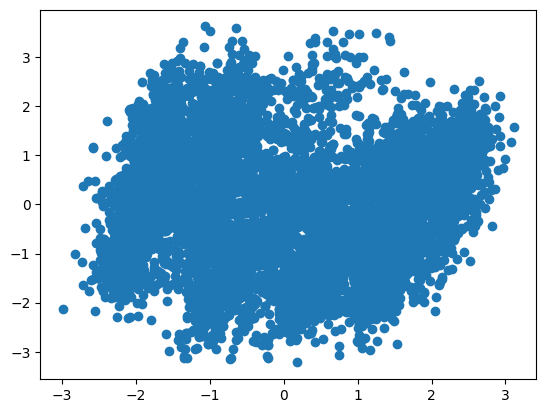

In [278]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=17)

principalComponents = pca.fit_transform(x)
Target = 'OG/GEN'
columns = ['Type1','Type2','Item','Nature','HP','Atk','Def','SpAtk','SpDef','Speed','Ability','M1','M2','M3','M4','','OG/GEN']
for i in range(len(columns)):
    if columns[i] == Target:
        columns[i] = "Target"
        break
Targets = []
princArray = []
for j in range(len(lines)):
    #print(lines[j])
    line = lines[j].split(",")
    if Target == 'OG/GEN':
        Targets.append(0)
    else:
        Targets.append(line[i])
    if Target != 'OG/GEN':
        if line[i] not in princArray:
            
            princArray.append(line[i])
    if Target == 'OG/GEN' and len(princArray) < 1:
        for i in range(13):
            princArray.append(float(i))


principalDf = pd.DataFrame(data = principalComponents,columns = columns)
#Focus Sash,Timid,0,0,0,252,0,252,Chlorophyll,Sleep Powder,Sludge Bomb,After You,Strength Sap,

principalKf = pd.DataFrame(data = Targets,columns = [Target])

finalDf = pd.concat([principalDf, principalKf], axis = 1)
#finalDf = principalDf
#finalDf = pd.concat([principalDf, principalKf], axis = 1)


for i in range(OGCounter,OGCounter+GennedCounter):
    finalDf['OG/GEN'][i] = 1.0
AllGenerations.pop(0)
AllGenerations.insert(0,[])
print(len(AllGenerations))
counter = 0
prev = OGCounter+GennedCounter
for j in range(1,len(AllGenerations)):
    print(prev,prev+len(AllGenerations[j]))
    
    for i in range(prev,prev+len(AllGenerations[j])):  
        counter += 1
        finalDf['OG/GEN'][i] = j+2
        
        #print(j)
        #if math.isnan(j):
            #print(j)
        #print(finalDf['OG/GEN'][i],j)
        #print(len(xRow))
    prev = prev+len(AllGenerations[j])
#print(finalDf[[Target]])
print(counter)
plt.scatter(finalDf['Type1'],finalDf['Type2'])

TypeError: expected non-empty vector for x

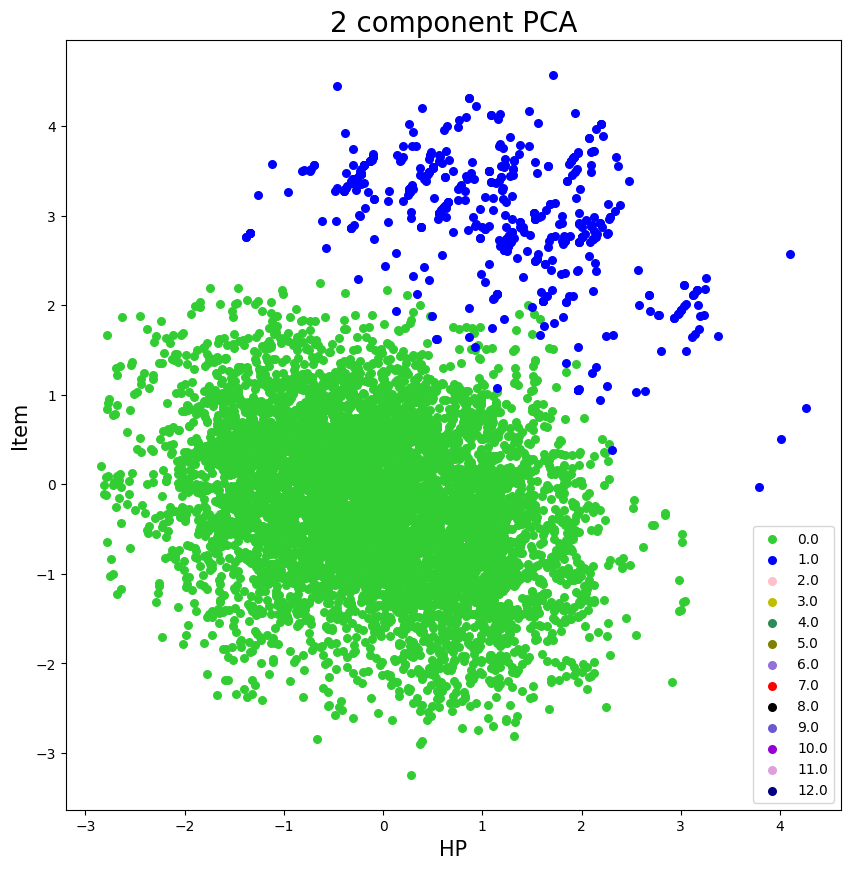

In [282]:
import matplotlib.pyplot as plt
PrincipleComponent1 = 'HP'
PrincipleComponent2 = 'Item'
#['Type1','InvalidType','Item','Nature','HP','Atk','Def','SpAtk','SpDef','Speed','Ability','M1','M2','M3','M4','']
#s = [(2*n)+1 for n in range(len(unique(kf.loc[:, ['Attack']].values)))]
#print(s)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(PrincipleComponent1, fontsize = 15)
ax.set_ylabel(PrincipleComponent2, fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = princArray
colors = ['limegreen', 'b', 'pink','y','seagreen','olive','mediumpurple','red','black','slateblue','darkviolet',
          'plum','navy','wheat','lightblue','orchid','g','firebrick']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[Target].fillna(1) == target
    #print(target)
    #print(np.array(indicesToKeep,dtype=np.bool))
    ax.scatter(finalDf.fillna(1).loc[indicesToKeep, PrincipleComponent1]
               , finalDf.fillna(1).loc[indicesToKeep, PrincipleComponent2]
               , c = color
               , s = 30)
    #find line of best fit
    

    

    #add line of best fit to plot
     
ax.legend(targets)
#print(finalDf.loc[indicesToKeep, PrincipleComponent1])
a, b = np.polyfit(finalDf.loc[indicesToKeep, PrincipleComponent1], finalDf.loc[indicesToKeep, PrincipleComponent2], 1)
#ax.plot(finalDf.loc[indicesToKeep, PrincipleComponent1], a*finalDf.loc[indicesToKeep, PrincipleComponent1]+b,color="orange") 
ax.grid()

Focus Sash
Rock
Flying
Safety Goggles
None
Weakness Policy
Coba Berry
Life Orb
Ghost
Dark


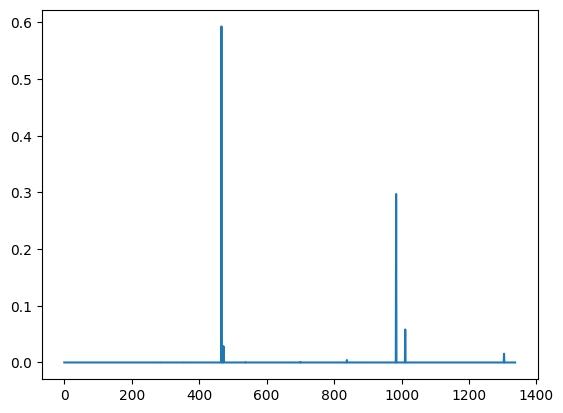

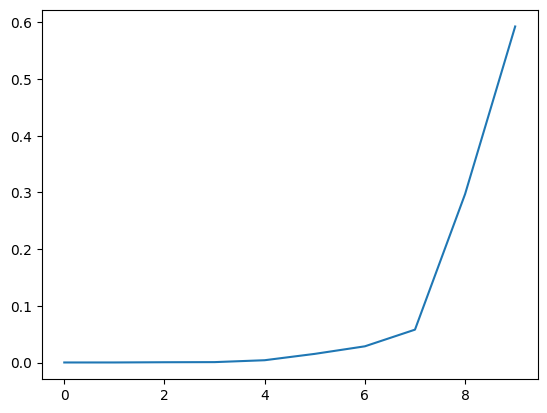

['Dragon', 'Coba Berry', 'Ghost', 'Life Orb', 'None', 'Weakness Policy', 'Focus Sash', 'Safety Goggles', 'Rock', 'Flying']


In [228]:
import matplotlib.pyplot as plt
inp = torch.tensor(encode(["Fire"]), dtype=torch.long)#encode()
final = model.generateAttentionMap(inp.to(device))
out = final[0][0]
#print([0])
for ind in final[0][0].tolist():
    print(decode([ind]))
probs = final[1]

plot_probs = probs[0].tolist()
plt.plot(plot_probs)
plt.show()
sortedProbsIndexes = sorted(range(len(plot_probs)), key=lambda k: plot_probs[k])[-10:]
plot_probs.sort()
xAxis = []
for x in sortedProbsIndexes:
    xAxis.append(decode([x]))
#plt.tick_params(axis='x', which='major', labelsize="8")
plt.plot(plot_probs[-10:])
plt.show()
#for top in plot_probs[-10:]:
#    print(decode([top]))
print(xAxis)